In [1]:
# import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import rasterio
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
# import metpy
# from metpy.plots import USCOUNTIES

import xgrid_utils

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [47]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [3]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [4]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirSSP = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/SSP/population/ssp2'

In [5]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [6]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1

In [7]:
ssp2_pop = xr.open_dataset(f'{dirSSP}/ssp2_2020.nc')
# regridder = xe.Regridder(ssp2_pop, land_sea_mask.rename({'latitude':'lat','longitude':'lon'}), 'conservative', reuse_weights=False)
# # Apply regridding
# ssp2_pop_regrid = regridder(ssp2_pop)

In [8]:
# load iizumi
iizumi_maize_ds = xr.Dataset()
iizumi_soy_ds = xr.Dataset()
iizumi_wheat_ds = xr.Dataset()

for y,year in enumerate(range(1981,2016+1)):
    
    iizumi_maize_ds_cur= xr.open_dataset('%s/iizumi/maize_major/yield_%d.nc4'%(dirHeatData,year))
    iizumi_maize_ds_cur = iizumi_maize_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_maize_ds = iizumi_maize_ds_cur
    else:
        iizumi_maize_ds = xr.concat([iizumi_maize_ds, iizumi_maize_ds_cur], dim='time')
        
        
    iizumi_soy_ds_cur= xr.open_dataset('%s/iizumi/soybean/yield_%d.nc4'%(dirHeatData,year))
    iizumi_soy_ds_cur = iizumi_soy_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_soy_ds = iizumi_soy_ds_cur
    else:
        iizumi_soy_ds = xr.concat([iizumi_soy_ds, iizumi_soy_ds_cur], dim='time')
        

    iizumi_wheat_ds_cur= xr.open_dataset('%s/iizumi/wheat/yield_%d.nc4'%(dirHeatData,year))
    iizumi_wheat_ds_cur = iizumi_wheat_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_wheat_ds = iizumi_wheat_ds_cur
    else:
        iizumi_wheat_ds = xr.concat([iizumi_wheat_ds, iizumi_wheat_ds_cur], dim='time')

iizumi_maize_ds = iizumi_maize_ds.reindex(lat=list(reversed(iizumi_maize_ds.lat)))
iizumi_soy_ds = iizumi_soy_ds.reindex(lat=list(reversed(iizumi_soy_ds.lat)))
iizumi_wheat_ds = iizumi_wheat_ds.reindex(lat=list(reversed(iizumi_wheat_ds.lat)))

In [9]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_irr = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear', reuse_weights=True)

irrigationData_regrid = regridder_irr(irrigationData)
irrigationData_regrid_1d = irrigationData_regrid.reshape([irrigationData_regrid.size,1])

irrigationData_regrid_da = xr.DataArray(
    irrigationData_regrid,  # The data (NumPy array)
    dims=["lat", "lon"],  # Name the dimensions
    coords={"lat": lat, "lon": lon},  # Assign the coordinates
    name="crop_ha_regrid"  # Optional: give it a name
)
irrigationData_regrid_da = irrigationData_regrid_da.sel(lat=slice(60,-60))

Reuse existing file: bilinear_2160x4320_721x1440.nc


In [10]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)
    crop_ha_regrid_1d = crop_ha_regrid.reshape([crop_ha_regrid.size, 1])
    
crop_ha_regrid_da = xr.DataArray(
    crop_ha_regrid,  # The data (NumPy array)
    dims=["lat", "lon"],  # Name the dimensions
    coords={"lat": lat, "lon": lon},  # Assign the coordinates
    name="crop_ha_regrid"  # Optional: give it a name
)
crop_ha_regrid_da = crop_ha_regrid_da.sel(lat=slice(60,-60))

In [11]:
recalc=False

def drop_coordinate(ds):
    # Replace 'your_coordinate_name' with the actual name of the coordinate you want to drop
    return ds.drop_vars('quantile', errors='ignore')

if recalc:
    days_above_tx90 = xr.open_mfdataset('output/days_above_tx_pct/days_above_tx0.9_*.nc', preprocess=drop_coordinate, combine='nested', concat_dim='time')
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    days_above_tx90['time'] = time_dim
    days_above_tx90 = days_above_tx90.where(land_sea_mask_binary)
    days_above_tx90 = days_above_tx90.sel(latitude=slice(60,-60))
    days_above_tx90.to_netcdf('intermediate/n_days_above_tx90.nc')
else:
    days_above_tx90 = xr.open_dataset('intermediate/n_days_above_tx90.nc')
    
if recalc:
    days_above_tx99 = xr.open_mfdataset('output/days_above_tx_pct/days_above_tx0.99_*.nc', preprocess=drop_coordinate, combine='nested', concat_dim='time')
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    days_above_tx99['time'] = time_dim
    days_above_tx99 = days_above_tx99.where(land_sea_mask_binary)
    days_above_tx99 = days_above_tx99.sel(latitude=slice(60,-60))
    days_above_tx99.to_netcdf('intermediate/n_days_above_tx99.nc')
else:
    days_above_tx99 = xr.open_dataset('intermediate/n_days_above_tx99.nc')
    
    


In [12]:
recalc=False
if recalc:
    days_above_tw90 = xr.open_mfdataset('output/days_above_tw_pct/days_above_tw0.9_*.nc', combine='nested', concat_dim='time')
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    days_above_tw90['time'] = time_dim
    days_above_tw90 = days_above_tw90.where(land_sea_mask_binary)
    days_above_tw90 = days_above_tw90.drop(['quantile'])
    days_above_tw90 = days_above_tw90.sel(latitude=slice(60,-60))
    days_above_tw90.to_netcdf('intermediate/n_days_above_tw90.nc')
else:
    days_above_t290 = xr.open_dataset('intermediate/n_days_above_tw90.nc')
    
if recalc:
    days_above_tw99 = xr.open_mfdataset('output/days_above_tw_pct/days_above_tw0.99_*.nc', combine='nested', concat_dim='time')
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    days_above_tw99['time'] = time_dim
    days_above_tw99 = days_above_tw99.where(land_sea_mask_binary)
    days_above_tw99 = days_above_tw99.drop(['quantile'])
    days_above_tw99 = days_above_tw99.sel(latitude=slice(60,-60))
    days_above_tw99.to_netcdf('intermediate/n_days_above_tw99.nc')
else:
    days_above_tw99 = xr.open_dataset('intermediate/n_days_above_tw99.nc')

In [13]:
# import os

# # Specify the directory to search for files
# directory = 'output/huss_on_tw'

# # Loop through each file in the directory
# for year in range(1981,2021):
#     filename = f'huss_on_warm_season_tw_deciles_{year}.nc'
#     file_path = os.path.join(directory, filename)
#     print(file_path)
#     if os.path.isfile(file_path):
#         os.remove(file_path)
    
    


In [14]:
era5_monthly_tp_trend = []

era5_monthly_tp_r_tx_tw_slope = []
era5_monthly_tp_r_tx_tw_r2 = []
era5_monthly_tp_r_tx_tw_corr = []


for m in range(0, 12):
    
    with open(f'era5_tp_monthly_trend_{m}.dat', 'rb') as f:
        cur_era5_monthly_tp_trend = pickle.load(f)
        if m == 0:
            era5_monthly_tp_trend = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
        era5_monthly_tp_trend[m,:,:] = cur_era5_monthly_tp_trend
    
    with open(f'era5_monthly_tp_r_tx_tw_{m+1}.dat', 'rb') as f:
        cur_era5_monthly_tp_r_tx_tw = pickle.load(f)
        
        if m == 0:
            era5_monthly_tp_r_tx_tw_slope = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
            era5_monthly_tp_r_tx_tw_r2 = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
        
        era5_monthly_tp_r_tx_tw_slope[m,:,:] = cur_era5_monthly_tp_r_tx_tw['era5_monthly_tp_r_tx_tw_slope']
        era5_monthly_tp_r_tx_tw_r2[m,:,:] = cur_era5_monthly_tp_r_tx_tw['era5_monthly_tp_r_tx_tw_r2']
    
    

era5_monthly_tp_r_tx_tw_lag_slope = []
era5_monthly_tp_r_tx_tw_lag_r2 = []

for l in range(0,5+1):
    with open(f'era5_monthly_tp_r_tx_tw_lag{l}.dat', 'rb') as f:
        cur_era5_monthly_tp_corr_lag = pickle.load(f)
        
        if l == 0:
            era5_monthly_tp_r_tx_tw_lag_slope = np.full([6, cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[0], cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[1]], np.nan)
            era5_monthly_tp_r_tx_tw_lag_r2 = np.full([6, cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[0], cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[1]], np.nan)
            
            era5_monthly_tp_r_tx_tw_corr = cur_era5_monthly_tp_corr_lag['monthly_tp_corr']
        
        era5_monthly_tp_r_tx_tw_lag_slope[l,:,:] = cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope']
        era5_monthly_tp_r_tx_tw_lag_r2[l,:,:] = cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_r2']
        

In [15]:
era5_monthly_tp_r_tx_tw_r2_max = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)
era5_monthly_tp_r_tx_tw_r2_max_ind = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)


for xlat in range(era5_monthly_tp_r_tx_tw_r2.shape[1]):
    for ylon in range(era5_monthly_tp_r_tx_tw_r2.shape[2]):
        cur = era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon]
        if np.where(~np.isnan(cur))[0].size > 10:
            era5_monthly_tp_r_tx_tw_r2_max[xlat, ylon] = np.nanmax(era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon])
            era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon] = np.nanargmax(era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon])



In [16]:
# extract monthly precip trends for month with max r2 at each grid cell

era5_monthly_tp_trend_max_r2 = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)

for xlat in range(era5_monthly_tp_r_tx_tw_r2_max_ind.shape[0]):
    for ylon in range(era5_monthly_tp_r_tx_tw_r2_max_ind.shape[1]):
        if ~np.isnan(era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon]):
            era5_monthly_tp_trend_max_r2[xlat, ylon] = era5_monthly_tp_trend[int(era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon]), xlat, ylon]*10*1000

In [17]:
era5_monthly_tp = []
for y in range(1981, 2019+1):
    cur_ds_era5_tp = xr.open_mfdataset(f'era5_tp_monthly_{y}.nc')
    era5_monthly_tp.append(cur_ds_era5_tp)

ds_era5_monthly_tp = xr.concat(era5_monthly_tp, dim='time')
ds_era5_monthly_tp.load();

In [18]:
recalc = False

In [19]:


from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tx_on_tw_full = xr.open_mfdataset('output/tasmax_on_tw/tasmax_on_tww*.nc', combine='nested', concat_dim='time')
    tx_on_tw_full = tx_on_tw_full.where(land_sea_mask_binary)
    tx_on_tw_full = tx_on_tw_full.rename({'__xarray_dataarray_variable__':'tx_on_tww'})
    tx_on_tw_full['tx_on_tww'] -= 273.15
    tx_on_tw_full = tx_on_tw_full.sel(latitude=slice(60,-60))
    tx_on_tw_full.load()

    tx_on_tw_full.to_netcdf('intermediate/tx_on_tw_full.nc')

else:
    tx_on_tw_full = xr.open_dataset('intermediate/tx_on_tw_full.nc')
    
tx_on_tw_mean = tx_on_tw_full.mean(dim='time')
tx_on_tw_ts = xgrid_utils.calc_spatial_mean(tx_on_tw_full)
# tx_on_tw_ts.to_netcdf('intermediate/tx_on_tw_ts.nc')


In [20]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tw_on_tx_full = xr.open_mfdataset('output/tw_max_on_tx/tw_max_on_txx*.nc', combine='nested', concat_dim='time')
    tw_on_tx_full = tw_on_tx_full.where(land_sea_mask_binary)
    tw_on_tx_full = tw_on_tx_full.rename({'__xarray_dataarray_variable__':'tw_on_txx'})
    tw_on_tx_full = tw_on_tx_full.sel(latitude=slice(60,-60))
    tw_on_tx_full.load()

    tw_on_tx_full.to_netcdf('intermediate/tw_on_tx_full.nc')
else:
    tw_on_tx_full = xr.open_dataset('intermediate/tw_on_tx_full.nc')

# tw_on_tx_full['tw'][-1,:,:,:] += 273.15
    
tw_on_tx_mean = tw_on_tx_full.mean(dim='time')
tw_on_tx_ts = xgrid_utils.calc_spatial_mean(tw_on_tx_full)
# tw_on_tx_ts.to_netcdf('intermediate/tw_on_tx_ts.nc')


In [21]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tx_on_tx_full = xr.open_mfdataset('output/tasmax_on_tx/tasmax_on_txx*.nc', combine='nested', concat_dim='time')
    tx_on_tx_full = tx_on_tx_full.where(land_sea_mask_binary)
    tx_on_tx_full = tx_on_tx_full.rename({'__xarray_dataarray_variable__':'tx_on_txx'})
    tx_on_tx_full['tx_on_txx'] -= 273.15
    tx_on_tx_full = tx_on_tx_full.sel(latitude=slice(60,-60))
    tx_on_tx_full.load()

    tx_on_tx_full.to_netcdf('intermediate/tx_on_tx_full.nc')

else:
    tx_on_tx_full = xr.open_dataset('intermediate/tx_on_tx_full.nc')

tx_on_tx_ts = xgrid_utils.calc_spatial_mean(tx_on_tx_full)
tx_on_tx_mean = tx_on_tx_full.mean(dim='time')
# tx_on_tx_ts.to_netcdf('intermediate/tx_on_tx_ts.nc')



In [22]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tw_on_tw_full = xr.open_mfdataset('output/tw_max_on_tw/tw_max_on_tww*.nc', combine='nested', concat_dim='time')
    tw_on_tw_full = tw_on_tw_full.where(land_sea_mask_binary)
    tw_on_tw_full = tw_on_tw_full.rename({'__xarray_dataarray_variable__':'tw_on_tww'})
    tw_on_tw_full = tw_on_tw_full.sel(latitude=slice(60,-60))
    tw_on_tw_full.load()

    tw_on_tw_full.to_netcdf('intermediate/tw_on_tw_full.nc')
else:
    tw_on_tw_full = xr.open_dataset('intermediate/tw_on_tw_full.nc')

tw_on_tw_ts = xgrid_utils.calc_spatial_mean(tw_on_tw_full)
tw_on_tw_mean = tw_on_tw_full.mean(dim='time')
# tw_on_tw_ts.to_netcdf('intermediate/tw_on_tw_ts.nc')




In [23]:
recalc=False

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    huss_on_txx_full = xr.open_mfdataset('output/huss_on_tx/huss_on_txx_*.nc', combine='nested', concat_dim='time')
    huss_on_txx_full = huss_on_txx_full.where(land_sea_mask_binary)
    huss_on_txx_full = huss_on_txx_full.sel(latitude=slice(60,-60))
    huss_on_txx_full = huss_on_txx_full.rename({'__xarray_dataarray_variable__':'huss_on_txx'})
    huss_on_txx_full.load()

    huss_on_txx_full.to_netcdf('intermediate/huss_on_txx.nc')
else:
    huss_on_txx_full = xr.open_dataset('intermediate/huss_on_txx.nc')

huss_on_txx_ts = xgrid_utils.calc_spatial_mean(huss_on_txx_full)

if recalc:
    huss_on_txx_ts.to_netcdf('intermediate/huss_on_txx_ts.nc')



In [24]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    huss_on_tww_full = xr.open_mfdataset('output/huss_on_tw/huss_on_tww_*.nc', combine='nested', concat_dim='time')
    huss_on_tww_full = huss_on_tww_full.where(land_sea_mask_binary)
    huss_on_tww_full = huss_on_tww_full.sel(latitude=slice(60,-60))
    huss_on_tww_full = huss_on_tww_full.rename({'__xarray_dataarray_variable__':'huss_on_tww'})
    huss_on_tww_full.load()

    huss_on_tww_full.to_netcdf('intermediate/huss_on_tww.nc')
else:
    huss_on_tww_full = xr.open_dataset('intermediate/huss_on_tww.nc')

huss_on_tww_ts = xgrid_utils.calc_spatial_mean(huss_on_tww_full)

if recalc:
    huss_on_tww_ts.to_netcdf('intermediate/huss_on_tww_ts.nc')



In [25]:
recalc=False

In [26]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    vpd_daily_mean_on_tww_full = xr.open_mfdataset('output/vpd_daily_mean_on_tw/vpd_daily_mean_on_tww_*.nc', combine='nested', concat_dim='time')
    vpd_daily_mean_on_tww_full = vpd_daily_mean_on_tww_full.where(land_sea_mask_binary)
    vpd_daily_mean_on_tww_full = vpd_daily_mean_on_tww_full.sel(latitude=slice(60,-60))
    vpd_daily_mean_on_tww_full = vpd_daily_mean_on_tww_full.rename({'__xarray_dataarray_variable__':'vpd_daily_mean_on_tww'})
    vpd_daily_mean_on_tww_full.load()

    vpd_daily_mean_on_tww_full.to_netcdf('intermediate/vpd_daily_mean_on_tww.nc')
else:
    vpd_daily_mean_on_tww_full = xr.open_dataset('intermediate/vpd_daily_mean_on_tww.nc')

vpd_daily_mean_on_tww_ts = xgrid_utils.calc_spatial_mean(vpd_daily_mean_on_tww_full)



In [27]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    vpd_daily_mean_on_txx_full = xr.open_mfdataset('output/vpd_daily_mean_on_tx/vpd_daily_mean_on_txx_*.nc', combine='nested', concat_dim='time')
    vpd_daily_mean_on_txx_full = vpd_daily_mean_on_txx_full.where(land_sea_mask_binary)
    vpd_daily_mean_on_txx_full = vpd_daily_mean_on_txx_full.sel(latitude=slice(60,-60))
    vpd_daily_mean_on_txx_full = vpd_daily_mean_on_txx_full.rename({'__xarray_dataarray_variable__':'vpd_daily_mean_on_txx'})
    vpd_daily_mean_on_txx_full.load()

    vpd_daily_mean_on_txx_full.to_netcdf('intermediate/vpd_daily_mean_on_txx.nc')
else:
    vpd_daily_mean_on_txx_full = xr.open_dataset('intermediate/vpd_daily_mean_on_txx.nc')

vpd_daily_mean_on_txx_ts = xgrid_utils.calc_spatial_mean(vpd_daily_mean_on_txx_full)



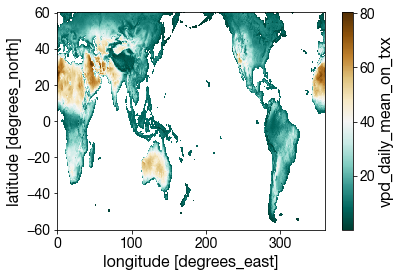

In [28]:
vpd_daily_mean_on_txx_full.vpd_daily_mean_on_txx.mean(dim='time').plot(cmap='BrBG_r')

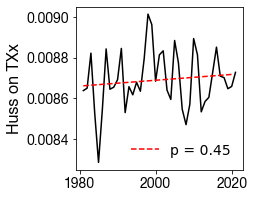

In [69]:
x_var = np.arange(1981,2022)
y_var = huss_on_txx_ts.huss_on_txx.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p = %.2f'%mdl.pvalues[1])
plt.ylabel('Huss on TXx')
# plt.yticks([-3.5, -3.4, -3.3, -3.2, -3.1])
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('tx|tww-txx-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

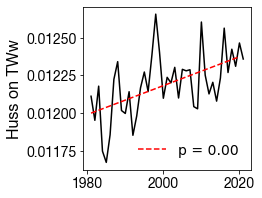

In [423]:
x_var = np.arange(1981,2022)
y_var = huss_on_tww_ts.huss_on_tww.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p = %.2f'%mdl.pvalues[1])
plt.ylabel('Huss on TWw')
# plt.yticks([-3.5, -3.4, -3.3, -3.2, -3.1])
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('tx|tww-txx-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


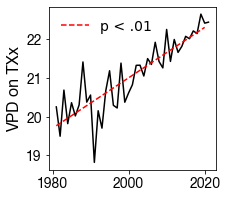

In [24]:
x_var = np.arange(1981,2022)
y_var = vpd_daily_mean_on_txx_ts.vpd_daily_mean_on_txx.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('VPD on TXx')
# plt.yticks([-3.5, -3.4, -3.3, -3.2, -3.1])
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('tx|tww-txx-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [29]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_huss_corr_full = xr.open_mfdataset('output/tx_huss_corr/tx_huss_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time', combine='nested')
tx_huss_corr_full['time'] = time_dim
tx_huss_corr_full = tx_huss_corr_full.rename({'__xarray_dataarray_variable__':'tx_huss_corr'})
tx_huss_corr_full = tx_huss_corr_full.where(land_sea_mask_binary)
tx_huss_corr_full = tx_huss_corr_full.sel(latitude=slice(60,-60))
tx_huss_corr_full.load()
# tx_huss_corr_full.to_netcdf('intermediate/tx_huss_corr_full.nc')


tx_huss_corr_mean = tx_huss_corr_full.mean(dim='time')
tx_huss_corr_ts = xgrid_utils.calc_spatial_mean(tx_huss_corr_full)

# tx_huss_corr_ts = tx_huss_corr_full.mean(dim=['latitude', 'longitude'])

# tx_huss_corr_mean.to_netcdf('intermediate/tx_huss_corr_mean.nc')
# tx_huss_corr_ts.to_netcdf('intermediate/tx_huss_corr_ts.nc')

In [30]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)

tx_tw_corr_full = tx_tw_corr_full.sel(latitude=slice(60,-60))
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')
tx_tw_corr_ts = xgrid_utils.calc_spatial_mean(tx_tw_corr_full)
# tx_tw_corr_ts.to_netcdf('intermediate/tx_tw_corr_ts.nc')
# tx_tw_corr_full.to_netcdf('intermediate/tx_tw_corr.nc')





In [31]:
with open('era5_huss_on_txx_per_rtet.dat', 'rb') as f:
    era5_huss_on_txx_per_rtet = pickle.load(f)
with open('era5_huss_on_tww_per_rtet.dat', 'rb') as f:
    era5_huss_on_tww_per_rtet = pickle.load(f)
    
with open('era5_vpd_daily_mean_on_txx_per_rtet.dat', 'rb') as f:
    era5_vpd_daily_mean_on_txx_per_rtet = pickle.load(f)
with open('era5_vpd_daily_mean_on_tww_per_rtet.dat', 'rb') as f:
    era5_vpd_daily_mean_on_tww_per_rtet = pickle.load(f)
    
with open('era5_n_days_above_tx_90_per_rtet.dat', 'rb') as f:
    era5_n_days_above_tx90_per_rtet = pickle.load(f)
with open('era5_n_days_above_tx_99_per_rtet.dat', 'rb') as f:
    era5_n_days_above_tx99_per_rtet = pickle.load(f)
with open('era5_n_days_above_tx_99_per_rtet_ci.dat', 'rb') as f:
    era5_n_days_above_tx99_per_rtet_ci = pickle.load(f)
    
with open('era5_n_days_above_tw_90_per_rtet.dat', 'rb') as f:
    era5_n_days_above_tw90_per_rtet = pickle.load(f)
with open('era5_n_days_above_tw_99_per_rtet.dat', 'rb') as f:
    era5_n_days_above_tw99_per_rtet = pickle.load(f)
with open('era5_n_days_above_tw_99_per_rtet_ci.dat', 'rb') as f:
    era5_n_days_above_tw99_per_rtet_ci = pickle.load(f)

with open('era5_tw_on_txx_per_rtet_int.dat', 'rb') as f:
    era5_tw_on_txx_per_rtet_int = pickle.load(f)
with open('era5_tw_on_txx_per_rtet.dat', 'rb') as f:
    era5_tw_on_txx_per_rtet = pickle.load(f)
with open('era5_tw_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_txx_per_rtet_r2 = pickle.load(f)

with open('era5_tw_on_txx_minus_tw_on_tww_per_rtet.dat', 'rb') as f:
    era5_tw_on_txx_minus_tw_on_tww_per_rtet = pickle.load(f)
with open('era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2 = pickle.load(f)
    
with open('era5_tx_on_txx_per_rtet_int.dat', 'rb') as f:
    era5_tx_on_txx_per_rtet_int = pickle.load(f)
with open('era5_tx_on_txx_per_rtet.dat', 'rb') as f:
    era5_tx_on_txx_per_rtet = pickle.load(f)
with open('era5_tx_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_txx_per_rtet_r2 = pickle.load(f)
    
with open('era5_tw_on_tww_per_rtet_int.dat', 'rb') as f:
    era5_tw_on_tww_per_rtet_int = pickle.load(f)
with open('era5_tw_on_tww_per_rtet.dat', 'rb') as f:
    era5_tw_on_tww_per_rtet = pickle.load(f)
with open('era5_tw_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_tww_per_rtet_r2 = pickle.load(f)

with open('era5_tx_on_tww_per_rtet_int.dat', 'rb') as f:
    era5_tx_on_tww_per_rtet_int = pickle.load(f)
with open('era5_tx_on_tww_per_rtet.dat', 'rb') as f:
    era5_tx_on_tww_per_rtet = pickle.load(f)
with open('era5_tx_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_tww_per_rtet_r2 = pickle.load(f)
    
with open('era5_tx_on_tww_minus_tx_on_txx_per_rtet.dat', 'rb') as f:
    era5_tx_on_tww_minus_tx_on_txx_per_rtet = pickle.load(f)
with open('era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2 = pickle.load(f)
    
era5_n_days_above_tw99_per_rtet_da = xr.DataArray(
    era5_n_days_above_tw99_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
) 

era5_n_days_above_tw99_per_rtet_ci_da = xr.DataArray(
    era5_n_days_above_tw99_per_rtet_ci,  # Data
    dims=['latitude', 'longitude', "ci"],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values,  # Coordinate for longitude
        "ci":[0,1]
    }
) 

era5_n_days_above_tw90_per_rtet_da = xr.DataArray(
    era5_n_days_above_tw90_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)
    
era5_n_days_above_tx99_per_rtet_da = xr.DataArray(
    era5_n_days_above_tx99_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)    

era5_n_days_above_tx99_per_rtet_ci_da = xr.DataArray(
    era5_n_days_above_tx99_per_rtet_ci,  # Data
    dims=['latitude', 'longitude', "ci"],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values,  # Coordinate for longitude
        "ci":[0,1]
    }
) 

era5_n_days_above_tx90_per_rtet_da = xr.DataArray(
    era5_n_days_above_tx90_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)
    
era5_vpd_daily_mean_on_txx_per_rtet_da = xr.DataArray(
    era5_vpd_daily_mean_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)

era5_vpd_daily_mean_on_tww_per_rtet_da = xr.DataArray(
    era5_vpd_daily_mean_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)
    
era5_huss_on_txx_per_rtet_da = xr.DataArray(
    era5_huss_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)


era5_huss_on_tww_per_rtet_da = xr.DataArray(
    era5_huss_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)


    

# TW ON TWW
era5_tw_on_tww_per_rtet_da = xr.DataArray(
    era5_tw_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


era5_tw_on_tww_per_rtet_int_da = xr.DataArray(
    era5_tw_on_tww_per_rtet_int,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


era5_tw_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TW ON TXX MINUS TW ON TWW
era5_tw_on_txx_minus_tw_on_tww_per_rtet_da = xr.DataArray(
    era5_tw_on_txx_minus_tw_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TX ON TWW MINUS TX ON TXX
era5_tx_on_tww_minus_tx_on_txx_per_rtet_da = xr.DataArray(
    era5_tx_on_tww_minus_tx_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TW ON TXX
era5_tw_on_txx_per_rtet_da = xr.DataArray(
    era5_tw_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tw_on_txx_per_rtet_int_da = xr.DataArray(
    era5_tw_on_txx_per_rtet_int,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tw_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TX ON TXX
era5_tx_on_txx_per_rtet_da = xr.DataArray(
    era5_tx_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tx_on_txx_per_rtet_int_da = xr.DataArray(
    era5_tx_on_txx_per_rtet_int,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tx_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TX ON TWW
era5_tx_on_tww_per_rtet_da = xr.DataArray(
    era5_tx_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tx_on_tww_per_rtet_int_da = xr.DataArray(
    era5_tx_on_tww_per_rtet_int,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


era5_tx_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)
    

In [32]:
# load bootstrapped trends
era5_r_tx_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tw_on_tx_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tw_on_tx_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tx_on_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tx_on_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)

lat_skip = 20
for d in range(24):
    with open(f'era5_r_tx_tw_slope_bootstrap_100_decile{d}_2_26_4pm.dat', 'rb') as f:
        cur_era5_r_tx_tw_slice = pickle.load(f)
        era5_r_tx_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_slope'][0:20,:,:]
        era5_r_tx_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_int'][0:20,:,:]

        era5_r_tx_tw_vs_tw_on_tx_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_slope'][0:20,:,:]
        era5_r_tx_tw_vs_tw_on_tx_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_int'][0:20,:,:]

        era5_r_tx_tw_vs_tx_on_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_slope'][0:20,:,:]
        era5_r_tx_tw_vs_tx_on_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_int'][0:20,:,:]

In [33]:
era5_r_tx_tw_slope = np.moveaxis(era5_r_tx_tw_slope, 2, 0)
era5_r_tx_tw_int = np.moveaxis(era5_r_tx_tw_int, 2, 0)

era5_r_tx_tw_vs_tw_on_tx_slope = np.moveaxis(era5_r_tx_tw_vs_tw_on_tx_slope, 2, 0)
era5_r_tx_tw_vs_tw_on_tx_int = np.moveaxis(era5_r_tx_tw_vs_tw_on_tx_int, 2, 0)

era5_r_tx_tw_vs_tx_on_tw_slope = np.moveaxis(era5_r_tx_tw_vs_tx_on_tw_slope, 2, 0)
era5_r_tx_tw_vs_tx_on_tw_int = np.moveaxis(era5_r_tx_tw_vs_tx_on_tw_int, 2, 0)

In [34]:
era5_r_tx_tw_slope_da = xr.DataArray(
    data=era5_r_tx_tw_slope,  # Use your data array here
    dims=["bootstrap", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "bootstrap":np.arange(0,100),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

era5_r_tx_tw_slope_spatial_mean = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_slope_da)

era5_r_tx_tw_int_da = xr.DataArray(
    data=era5_r_tx_tw_int,  # Use your data array here
    dims=["bootstrap", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "bootstrap":np.arange(0,100),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

era5_r_tx_tw_int_spatial_mean = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_int_da)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


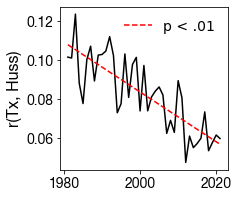

In [35]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = tx_huss_corr_ts.tx_huss_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))

# for b in range(era5_r_tx_tw_slope_spatial_mean.bootstrap.size):
#     plt.plot([x1, x2], [era5_r_tx_tw_int_spatial_mean.values[b]+era5_r_tx_tw_slope_spatial_mean[b]*0, era5_r_tx_tw_int_spatial_mean.values[b]+era5_r_tx_tw_slope_spatial_mean[b]*(x2-x1)], '-', c='#aaaaaa')
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Huss)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.savefig('r(tx,huss)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

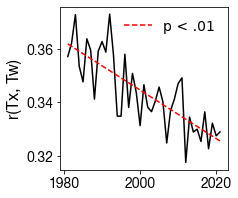

In [265]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = tx_tw_corr_ts.tx_tw_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))

# for b in range(era5_r_tx_tw_slope_spatial_mean.bootstrap.size):
#     plt.plot([x1, x2], [era5_r_tx_tw_int_spatial_mean.values[b]+era5_r_tx_tw_slope_spatial_mean[b]*0, era5_r_tx_tw_int_spatial_mean.values[b]+era5_r_tx_tw_slope_spatial_mean[b]*(x2-x1)], '-', c='#aaaaaa')
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Tw)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('r(tx,tw)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [266]:
lat_ranges_step = -5
lat_ranges = np.arange(60, -60, lat_ranges_step)

tx_tw_corr_trend_lat_ranges = np.full(lat_ranges.size, np.nan)
tx_tw_corr_pval_lat_ranges = np.full(lat_ranges.size, np.nan)

huss_sm_corr_trend_lat_ranges = np.full(lat_ranges.size, np.nan)
huss_sm_corr_pval_lat_ranges = np.full(lat_ranges.size, np.nan)

for l in range(lat_ranges.size-1):
    l1 = lat_ranges[l]
    l2 = lat_ranges[l+1]
    
    tx_tw_corr_cur = tx_tw_corr_full.tx_tw_corr.sel(latitude=slice(l1,l2)).mean(dim=['latitude', 'longitude'])
#     huss_sm_corr_cur = huss_sm_corr_full.huss_sm_corr.sel(latitude=slice(l1,l2)).mean(dim=['latitude', 'longitude'])
    
    nn = np.where((~np.isnan(tx_tw_corr_cur.values)))[0]
    if nn.size > 0:
        X = sm.add_constant(range(nn.size))
        mdl = sm.OLS(tx_tw_corr_cur.values[nn], X).fit()

        tx_tw_corr_trend_lat_ranges[l] = mdl.params[1]*10
        tx_tw_corr_pval_lat_ranges[l] = mdl.pvalues[1]
        
#     nn = np.where((~np.isnan(huss_sm_corr_cur.values)))[0]
#     if nn.size > 0:
#         X = sm.add_constant(range(nn.size))
#         mdl = sm.OLS(huss_sm_corr_cur.values[nn], X).fit()

#         huss_sm_corr_trend_lat_ranges[l] = mdl.params[1]*10
#         huss_sm_corr_pval_lat_ranges[l] = mdl.pvalues[1]




Text(0.5, 0, 'r(Tx, Tw) trend\n(per decade)')

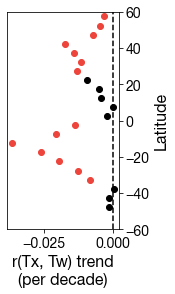

In [267]:
plt.figure(figsize=(2,4))
plt.ylim([-60,60])

# Calculate indexes where p value is less than .05
idx = tx_tw_corr_pval_lat_ranges < .05

# Plot data where p value is less than .05 in black
plt.plot(tx_tw_corr_trend_lat_ranges[idx], lat_ranges[idx]-lat_ranges_step/2, 'o', color='#ed443b')

# Plot data where p value is greater than or equal to .05 in red
plt.plot(tx_tw_corr_trend_lat_ranges[~idx], lat_ranges[~idx]-lat_ranges_step/2, 'o', color='k')


plt.plot([0,0], [-60, 60], '--k')
# plt.yticks([])
plt.ylabel('Latitude')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

# plt.xticks([-60,-30,0,30,60])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
# plt.savefig('r(tx,tw)-trend-by-lat.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [268]:
plt.figure(figsize=(3,3))

x_var = signal.detrend(tx_huss_corr_ts.tx_huss_corr.values)
y_var = signal.detrend(tx_tw_corr_ts.tx_tw_corr.values[0:-1])

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = -.025
x2 = 0.025

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', label='$R^2$ = %.2f'%mdl.rsquared)
plt.xlabel('Global mean r(Tx, Huss)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean r(Tx, Tw)\ndetrended anomaly')
font = FontProperties(size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

# plt.savefig('r(tx,tw)-r(tx,huss).png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

ValueError: operands could not be broadcast together with shapes (41,) (40,) 

<Figure size 216x216 with 0 Axes>

In [36]:
lsm = land_sea_mask_binary.sel(latitude=slice(60,-60))

In [37]:
recalc = False

if recalc:
    n_days_above_tw99_from_rtet_rand = np.full([50, 41, era5_n_days_above_tw99_per_rtet_ci_da.shape[0], era5_n_days_above_tw99_per_rtet_ci_da.shape[1]], np.nan)
    n_days_above_tx99_from_rtet_rand = np.full([50, 41, era5_n_days_above_tw99_per_rtet_ci_da.shape[0], era5_n_days_above_tw99_per_rtet_ci_da.shape[1]], np.nan)

    for xlat in range(era5_n_days_above_tw99_per_rtet_ci_da.shape[0]):

        if xlat%50==0:print(xlat)

        for ylon in range(era5_n_days_above_tw99_per_rtet_ci_da.shape[1]):

            if not lsm[xlat, ylon]: continue

#             v1 = era5_n_days_above_tw99_per_rtet_ci_da[xlat,ylon,0].values
#             v2 = era5_n_days_above_tw99_per_rtet_ci_da[xlat,ylon,1].values

#             if not np.isnan(v1) and not np.isnan(v2):
#                 m = np.random.uniform(v1,v2,50)
#                 m_reshaped = m[:, np.newaxis]  # Now m has size (10, 1)

#                 tx_tw_corr_values = tx_tw_corr_full.tx_tw_corr.values[:, xlat, ylon]
#                 mean_corr = np.nanmean(tx_tw_corr_values, axis=0)

#                 # Perform the broadcasted multiplication
#                 n_days_above_tw99_from_rtet_rand[:, :, xlat, ylon] = m_reshaped * (tx_tw_corr_values - mean_corr)
                
            
            v1 = era5_n_days_above_tx99_per_rtet_ci_da[xlat,ylon,0].values
            v2 = era5_n_days_above_tx99_per_rtet_ci_da[xlat,ylon,1].values

            if not np.isnan(v1) and not np.isnan(v2):
                m = np.random.uniform(v1,v2,50)
                m_reshaped = m[:, np.newaxis]  # Now m has size (10, 1)

                tx_tw_corr_values = tx_tw_corr_full.tx_tw_corr.values[:, xlat, ylon]
                mean_corr = np.nanmean(tx_tw_corr_values, axis=0)

                # Perform the broadcasted multiplication
                n_days_above_tx99_from_rtet_rand[:, :, xlat, ylon] = m_reshaped * (tx_tw_corr_values - mean_corr)

    with open('n_days_above_tw99_from_rtet_rand.dat', 'wb') as f:
        pickle.dump(n_days_above_tw99_from_rtet_rand, f, protocol=4)
    with open('n_days_above_tx99_from_rtet_rand.dat', 'wb') as f:
        pickle.dump(n_days_above_tx99_from_rtet_rand, f, protocol=4)
else:
    with open('n_days_above_tw99_from_rtet_rand.dat', 'rb') as f:
        n_days_above_tw99_from_rtet_rand = pickle.load(f)
    with open('n_days_above_tx99_from_rtet_rand.dat', 'rb') as f:
        n_days_above_tx99_from_rtet_rand = pickle.load(f)

In [38]:
tw_on_txx_from_rtet_da = era5_tw_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
tx_on_tww_from_rtet_da = era5_tx_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
tw_on_tww_from_rtet_da = era5_tw_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
tx_on_txx_from_rtet_da = era5_tx_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

huss_on_tww_from_rtet_da = era5_huss_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
huss_on_txx_from_rtet_da = era5_huss_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

vpd_daily_mean_on_txx_from_rtet_da = era5_vpd_daily_mean_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
vpd_daily_mean_on_tww_from_rtet_da = era5_vpd_daily_mean_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

n_days_above_tx90_from_rtet_da = era5_n_days_above_tx90_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
n_days_above_tx99_from_rtet_da = era5_n_days_above_tx99_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

n_days_above_tw90_from_rtet_da = era5_n_days_above_tw90_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
n_days_above_tw99_from_rtet_da = era5_n_days_above_tw99_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

tx_on_tww_minus_tx_on_txx_from_rtet_da = era5_tx_on_tww_minus_tx_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
tw_on_txx_minus_tw_on_tww_from_rtet_da = era5_tw_on_txx_minus_tw_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

In [39]:
n_days_above_tw99_from_rtet_rand_da = xr.DataArray(
    data=n_days_above_tw99_from_rtet_rand,  # Use your data array here
    dims=["n", "time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "n":np.arange(50),
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

n_days_above_tw99_from_rtet_da = xr.DataArray(
    data=np.moveaxis(n_days_above_tw99_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)


n_days_above_tw90_from_rtet_da = xr.DataArray(
    data=np.moveaxis(n_days_above_tw90_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

n_days_above_tx99_from_rtet_da = xr.DataArray(
    data=np.moveaxis(n_days_above_tx99_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)


n_days_above_tx90_from_rtet_da = xr.DataArray(
    data=np.moveaxis(n_days_above_tx90_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

vpd_daily_mean_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(vpd_daily_mean_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

vpd_daily_mean_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(vpd_daily_mean_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)


huss_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(huss_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

huss_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(huss_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tw_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tx_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tw_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tx_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_tww_minus_tx_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tx_on_tww_minus_tx_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_txx_minus_tw_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tw_on_txx_minus_tw_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)


# huss_on_txx_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(huss_on_txx_from_rtet_da)
# huss_on_tww_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(huss_on_tww_from_rtet_da)
tw_on_txx_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_from_rtet_da)
tx_on_tww_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_from_rtet_da)
tw_on_tww_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_tww_from_rtet_da)
tx_on_txx_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_txx_from_rtet_da)

tx_on_tww_minus_tx_on_txx_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_minus_tx_on_txx_from_rtet_da)
tw_on_txx_minus_tw_on_tww_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_minus_tw_on_tww_from_rtet_da)

In [40]:
recalc = False

if recalc:
    n_days_above_tx90_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    n_days_above_tx99_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    n_days_above_tx99_chg_from_rtet_ci = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size, 2], np.nan)
    n_days_above_tx99_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    
    n_days_above_tw90_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    n_days_above_tw99_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    n_days_above_tw99_chg_from_rtet_ci = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size, 2], np.nan)
    n_days_above_tw99_chg_from_rtet_rand = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size, n_days_above_tw99_from_rtet_rand_da.shape[0]], np.nan)
    n_days_above_tw99_chg_from_rtet_rand_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size, n_days_above_tw99_from_rtet_rand_da.shape[0]], np.nan)
    n_days_above_tw99_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    
    vpd_daily_mean_on_txx_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    vpd_daily_mean_on_txx_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    vpd_daily_mean_on_tww_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    vpd_daily_mean_on_tww_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    
    huss_on_txx_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    huss_on_txx_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    huss_on_tww_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    huss_on_tww_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    
    tw_on_txx_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tw_on_txx_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tx_on_tww_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tx_on_tww_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    
    tx_on_txx_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tx_on_txx_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tw_on_tww_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tw_on_tww_chg_from_rtet_p = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)

    for xlat in range(tx_tw_corr_full.tx_tw_corr.latitude.size):
        print(xlat)
        for ylon in range(tx_tw_corr_full.tx_tw_corr.longitude.size):
            if lsm[xlat, ylon]:
                
                for n in range(n_days_above_tw99_from_rtet_rand_da.shape[0]):
#                     ts = n_days_above_tw99_from_rtet_rand_da[n, :, xlat, ylon].values
#                     X = sm.add_constant(np.arange(ts.size))
#                     mdl = sm.OLS(ts,X).fit()
#                     n_days_above_tw99_chg_from_rtet_rand[xlat, ylon, n] = mdl.params[1]*ts.size
#                     n_days_above_tw99_chg_from_rtet_rand_p[xlat, ylon, n] = mdl.pvalues[1]
                    
                    
                    ts = n_days_above_tx99_from_rtet_rand_da[n, :, xlat, ylon].values
                    X = sm.add_constant(np.arange(ts.size))
                    mdl = sm.OLS(ts,X).fit()
                    n_days_above_tx99_chg_from_rtet_rand[xlat, ylon, n] = mdl.params[1]*ts.size
                    n_days_above_tx99_chg_from_rtet_rand_p[xlat, ylon, n] = mdl.pvalues[1]
            
#                 ts = n_days_above_tw99_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 n_days_above_tw99_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 n_days_above_tw99_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]
#                 n_days_above_tw99_chg_from_rtet_ci[xlat, ylon, 0] = mdl.conf_int(alpha=.05)[1,0]*ts.size
#                 n_days_above_tw99_chg_from_rtet_ci[xlat, ylon, 1] = mdl.conf_int(alpha=.05)[1,1]*ts.size
                
#                 ts = n_days_above_tw90_per_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 n_days_above_tw90_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
                
#                 ts = n_days_above_tx99_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 n_days_above_tx99_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 n_days_above_tx99_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]
#                 n_days_above_tx99_chg_from_rtet_ci[xlat, ylon, 0] = mdl.conf_int(alpha=.05)[1,0]*ts.size
#                 n_days_above_tx99_chg_from_rtet_ci[xlat, ylon, 1] = mdl.conf_int(alpha=.05)[1,1]*ts.size
                
#                 ts = n_days_above_tx90_per_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 n_days_above_tx90_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
                
#                 ts = vpd_daily_mean_on_txx_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 vpd_daily_mean_on_txx_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 vpd_daily_mean_on_txx_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]
                
#                 ts = vpd_daily_mean_on_tww_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 vpd_daily_mean_on_tww_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 vpd_daily_mean_on_tww_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]
                
#                 ts = huss_on_txx_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 huss_on_txx_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 huss_on_txx_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]

#                 ts = huss_on_tww_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 huss_on_tww_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 huss_on_tww_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]
                
#                 ts = tw_on_txx_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 tw_on_txx_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 tw_on_txx_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]

#                 ts = tx_on_tww_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 tx_on_tww_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 tx_on_tww_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]

#                 ts = tx_on_txx_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 tx_on_txx_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 tx_on_txx_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]

#                 ts = tw_on_tww_from_rtet_da[:, xlat, ylon].values
#                 X = sm.add_constant(np.arange(ts.size))
#                 mdl = sm.OLS(ts,X).fit()
#                 tw_on_tww_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
#                 tw_on_tww_chg_from_rtet_p[xlat, ylon] = mdl.pvalues[1]
                
    
    
#     with open('n_days_above_tw99_chg_from_rtet_rand.dat', 'wb') as f:
#         pickle.dump(n_days_above_tw99_chg_from_rtet_rand, f)
#     with open('n_days_above_tw99_chg_from_rtet_rand_p.dat', 'wb') as f:
#         pickle.dump(n_days_above_tw99_chg_from_rtet_rand_p, f)
    
#     with open('n_days_above_tw99_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(n_days_above_tw99_chg_from_rtet, f)
#     with open('n_days_above_tw99_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(n_days_above_tw99_chg_from_rtet_p, f)
#     with open('n_days_above_tw99_chg_from_rtet_ci.dat', 'wb') as f:
#         pickle.dump(n_days_above_tw99_chg_from_rtet_ci, f)
    
#     with open('n_days_above_tw90_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(n_days_above_tw90_chg_from_rtet, f)
    
#     with open('n_days_above_tx99_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(n_days_above_tx99_chg_from_rtet, f)
#     with open('n_days_above_tx99_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(n_days_above_tx99_chg_from_rtet_p, f)
#     with open('n_days_above_tx99_chg_from_rtet_ci.dat', 'wb') as f:
#         pickle.dump(n_days_above_tx99_chg_from_rtet_ci, f)
    
#     with open('n_days_above_tx90_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(n_days_above_tx90_chg_from_rtet, f)
    
#     with open('vpd_daily_mean_on_txx_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(vpd_daily_mean_on_txx_chg_from_rtet, f)
#     with open('vpd_daily_mean_on_txx_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(vpd_daily_mean_on_txx_chg_from_rtet_p, f)
        
#     with open('vpd_daily_mean_on_tww_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(vpd_daily_mean_on_tww_chg_from_rtet, f)
#     with open('vpd_daily_mean_on_tww_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(vpd_daily_mean_on_tww_chg_from_rtet_p, f)
    
#     with open('huss_on_txx_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(huss_on_txx_chg_from_rtet, f)
#     with open('huss_on_txx_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(huss_on_txx_chg_from_rtet_p, f)
#     with open('huss_on_tww_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(huss_on_tww_chg_from_rtet, f)
#     with open('huss_on_tww_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(huss_on_tww_chg_from_rtet_p, f)

#     with open('tw_on_txx_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(tw_on_txx_chg_from_rtet, f)
#     with open('tw_on_txx_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(tw_on_txx_chg_from_rtet_p, f)
#     with open('tx_on_tww_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(tx_on_tww_chg_from_rtet, f)
#     with open('tx_on_tww_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(tx_on_tww_chg_from_rtet_p, f)
    
#     with open('tx_on_txx_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(tx_on_txx_chg_from_rtet, f)
#     with open('tx_on_txx_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(tx_on_txx_chg_from_rtet_p, f)
        
#     with open('tw_on_tww_chg_from_rtet.dat', 'wb') as f:
#         pickle.dump(tw_on_tww_chg_from_rtet, f)
#     with open('tw_on_tww_chg_from_rtet_p.dat', 'wb') as f:
#         pickle.dump(tw_on_tww_chg_from_rtet_p, f)
else:
#     with open('n_days_above_tx99_chg_from_rtet_rand.dat', 'rb') as f:
#         n_days_above_tw99_chg_from_rtet_rand = pickle.load(f)
#     with open('n_days_above_tx99_chg_from_rtet_rand_p.dat', 'rb') as f:
#         n_days_above_tw99_chg_from_rtet_rand_p = pickle.load(f)
    
    with open('n_days_above_tw99_chg_from_rtet_rand.dat', 'rb') as f:
        n_days_above_tw99_chg_from_rtet_rand = pickle.load(f)
    with open('n_days_above_tw99_chg_from_rtet_rand_p.dat', 'rb') as f:
        n_days_above_tw99_chg_from_rtet_rand_p = pickle.load(f)
    
    with open('n_days_above_tw99_chg_from_rtet.dat', 'rb') as f:
        n_days_above_tw99_chg_from_rtet = pickle.load(f)
    with open('n_days_above_tw99_chg_from_rtet_p.dat', 'rb') as f:
        n_days_above_tw99_chg_from_rtet_p = pickle.load(f)
        
    with open('n_days_above_tw90_chg_from_rtet.dat', 'rb') as f:
        n_days_above_tw90_chg_from_rtet = pickle.load(f)
    with open('n_days_above_tx99_chg_from_rtet.dat', 'rb') as f:
        n_days_above_tx99_chg_from_rtet = pickle.load(f)
    with open('n_days_above_tx99_chg_from_rtet_p.dat', 'rb') as f:
        n_days_above_tx99_chg_from_rtet_p = pickle.load(f)
        
    with open('n_days_above_tx90_chg_from_rtet.dat', 'rb') as f:
        n_days_above_tx90_chg_from_rtet = pickle.load(f)
        
    with open('vpd_daily_mean_on_txx_chg_from_rtet.dat', 'rb') as f:
        vpd_daily_mean_on_txx_chg_from_rtet = pickle.load(f)
    with open('vpd_daily_mean_on_txx_chg_from_rtet_p.dat', 'rb') as f:
        vpd_daily_mean_on_txx_chg_from_rtet_p = pickle.load(f)
    
    with open('vpd_daily_mean_on_tww_chg_from_rtet.dat', 'rb') as f:
        vpd_daily_mean_on_tww_chg_from_rtet = pickle.load(f)
    with open('vpd_daily_mean_on_tww_chg_from_rtet_p.dat', 'rb') as f:
        vpd_daily_mean_on_tww_chg_from_rtet_p = pickle.load(f)
        
    with open('huss_on_txx_chg_from_rtet.dat', 'rb') as f:
        huss_on_txx_chg_from_rtet = pickle.load(f)
    with open('huss_on_txx_chg_from_rtet_p.dat', 'rb') as f:
        huss_on_txx_chg_from_rtet_p = pickle.load(f)
        
    with open('huss_on_tww_chg_from_rtet.dat', 'rb') as f:
        huss_on_tww_chg_from_rtet = pickle.load(f)
    with open('huss_on_tww_chg_from_rtet_p.dat', 'rb') as f:
        huss_on_tww_chg_from_rtet_p = pickle.load(f)
        
    with open('tw_on_txx_chg_from_rtet.dat', 'rb') as f:
        tw_on_txx_chg_from_rtet = pickle.load(f)
    with open('tw_on_txx_chg_from_rtet_p.dat', 'rb') as f:
        tw_on_txx_chg_from_rtet_p = pickle.load(f)
    
    with open('tx_on_tww_chg_from_rtet.dat', 'rb') as f:
        tx_on_tww_chg_from_rtet = pickle.load(f)
    with open('tx_on_tww_chg_from_rtet_p.dat', 'rb') as f:
        tx_on_tww_chg_from_rtet_p = pickle.load(f)
        
    with open('tx_on_txx_chg_from_rtet.dat', 'rb') as f:
        tx_on_txx_chg_from_rtet = pickle.load(f)
    with open('tx_on_txx_chg_from_rtet_p.dat', 'rb') as f:
        tx_on_txx_chg_from_rtet_p = pickle.load(f)
    
    with open('tw_on_tww_chg_from_rtet.dat', 'rb') as f:
        tw_on_tww_chg_from_rtet = pickle.load(f)
    with open('tw_on_tww_chg_from_rtet_p.dat', 'rb') as f:
        tw_on_tww_chg_from_rtet_p = pickle.load(f)
    

In [41]:
n_days_above_tw99_chg_from_rtet_rand_da = xr.DataArray(
    data=n_days_above_tw99_chg_from_rtet_rand,  # Use your data array here
    dims=["latitude", "longitude", "n"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values,  # Longitude coordinates
        "n":np.arange(n_days_above_tw99_chg_from_rtet_rand.shape[2])
    }
)


n_days_above_tw99_chg_from_rtet_p_da = xr.DataArray(
    data=n_days_above_tw99_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

n_days_above_tw99_chg_from_rtet_da = xr.DataArray(
    data=n_days_above_tw99_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

n_days_above_tw90_chg_from_rtet_da = xr.DataArray(
    data=n_days_above_tw90_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)



n_days_above_tx99_chg_from_rtet_p_da = xr.DataArray(
    data=n_days_above_tx99_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

n_days_above_tx99_chg_from_rtet_da = xr.DataArray(
    data=n_days_above_tx99_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

n_days_above_tx90_chg_from_rtet_da = xr.DataArray(
    data=n_days_above_tx90_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

vpd_daily_mean_on_txx_chg_from_rtet_da = xr.DataArray(
    data=vpd_daily_mean_on_txx_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

vpd_daily_mean_on_txx_chg_from_rtet_p_da = xr.DataArray(
    data=vpd_daily_mean_on_txx_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

vpd_daily_mean_on_tww_chg_from_rtet_da = xr.DataArray(
    data=vpd_daily_mean_on_tww_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

vpd_daily_mean_on_tww_chg_from_rtet_p_da = xr.DataArray(
    data=vpd_daily_mean_on_tww_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

huss_on_txx_chg_from_rtet_da = xr.DataArray(
    data=huss_on_txx_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

huss_on_txx_chg_from_rtet_p_da = xr.DataArray(
    data=huss_on_txx_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

huss_on_tww_chg_from_rtet_da = xr.DataArray(
    data=huss_on_tww_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

huss_on_tww_chg_from_rtet_p_da = xr.DataArray(
    data=huss_on_tww_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_txx_chg_from_rtet_da = xr.DataArray(
    data=tw_on_txx_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_txx_chg_from_rtet_p_da = xr.DataArray(
    data=tw_on_txx_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_tww_chg_from_rtet_da = xr.DataArray(
    data=tx_on_tww_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_tww_chg_from_rtet_p_da = xr.DataArray(
    data=tx_on_tww_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_txx_chg_from_rtet_da = xr.DataArray(
    data=tx_on_txx_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_txx_chg_from_rtet_p_da = xr.DataArray(
    data=tx_on_txx_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_tww_chg_from_rtet_da = xr.DataArray(
    data=tw_on_tww_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_tww_chg_from_rtet_p_da = xr.DataArray(
    data=tw_on_tww_chg_from_rtet_p,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)




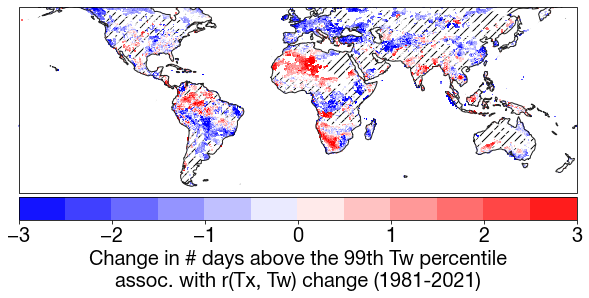

In [792]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -3
v2 = 3.1
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = n_days_above_tw99_chg_from_rtet_da.where(n_days_above_tw99_chg_from_rtet_p_da.values<.05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

density=3

ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, n_days_above_tw99_chg_from_rtet_p_da.where(n_days_above_tw99_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1, ax=plt.gca())
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in # days above the 99th Tw percentile\nassoc. with r(Tx, Tw) change (1981-2021)', fontsize=20)

# plt.savefig('days_above_tw99_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


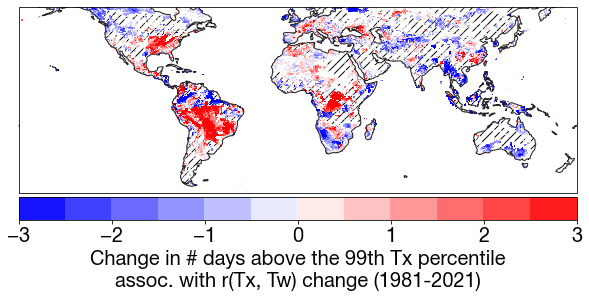

In [466]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -3
v2 = 3.1
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = n_days_above_tx99_chg_from_rtet_da.where(n_days_above_tx99_chg_from_rtet_p_da.values<.05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
density=3

ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, n_days_above_tx99_chg_from_rtet_p_da.where(n_days_above_tx99_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in # days above the 99th Tx percentile\nassoc. with r(Tx, Tw) change (1981-2021)', fontsize=20)

# plt.savefig('days_above_tx99_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


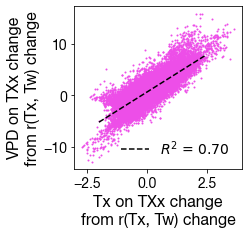

In [281]:
y1 = tx_on_txx_chg_from_rtet_da.where(tx_on_txx_chg_from_rtet_p_da.values < 0.05).values 
# y1 = huss_on_txx_chg_from_rtet_da.where(huss_on_txx_chg_from_rtet_p_da.values < 0.05).values 
y1 = y1.reshape([y1.size])
y2 = vpd_daily_mean_on_txx_chg_from_rtet_da.where(vpd_daily_mean_on_txx_chg_from_rtet_p_da.values < 0.05).values
y2 = y2.reshape([y2.size])

nn = np.where((~np.isnan(y1)) & (~np.isnan(y2)))[0]
X = sm.add_constant(y1[nn])
mdl = sm.OLS(y2[nn], X).fit()

x1 = -2
x2 = 2.4

plt.figure(figsize=(3,3))
# plt.xlim([-.004, .003])
plt.scatter(y1,y2, c='#ed4ee8', s=1)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)

# plt.xticks(np.arange(-.003, .0031, .003))

plt.xlabel('Tx on TXx change\nfrom r(Tx, Tw) change')
plt.ylabel('VPD on TXx change\nfrom r(Tx, Tw) change')

font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.savefig('vpd_on_txx_vs_tx_on_txx_from_rtet_scatter.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

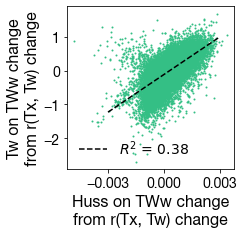

In [188]:
y1 = tw_on_tww_chg_from_rtet_da.where(tw_on_tww_chg_from_rtet_p_da.values < 0.05).values 
y1 = y1.reshape([y1.size])
y2 = huss_on_tww_chg_from_rtet_da.where(huss_on_tww_chg_from_rtet_p_da.values < 0.05).values
y2 = y2.reshape([y2.size])

nn = np.where((~np.isnan(y1)) & (~np.isnan(y2)))[0]
X = sm.add_constant(y2[nn])
mdl = sm.OLS(y1[nn], X).fit()

x1 = -.003
x2 = .003

plt.figure(figsize=(3,3))
# plt.xlim([-.004, .003])
plt.scatter(y2,y1, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)

plt.xticks(np.arange(-.003, .0031, .003))

plt.ylabel('Tw on TWw change\nfrom r(Tx, Tw) change')
plt.xlabel('Huss on TWw change\nfrom r(Tx, Tw) change')

font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.savefig('huss_on_tww_vs_tw_on_tww_from_rtet_scatter.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

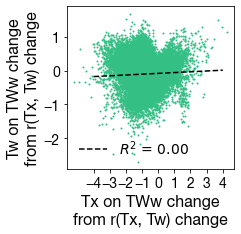

In [95]:
y1 = tw_on_tww_chg_from_rtet_da.where(tw_on_tww_chg_from_rtet_p_da.values < 0.05).values 
y1 = y1.reshape([y1.size])
y2 = tx_on_tww_chg_from_rtet_da.where(tx_on_tww_chg_from_rtet_p_da.values < 0.05).values
y2 = y2.reshape([y2.size])

nn = np.where((~np.isnan(y1)) & (~np.isnan(y2)))[0]
X = sm.add_constant(y2[nn])
mdl = sm.OLS(y1[nn], X).fit()

x1 = -4
x2 = 4

plt.figure(figsize=(3,3))
# plt.xlim([-.004, .003])
plt.scatter(y2,y1, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)

plt.xticks(np.arange(-4, 4.1, 1))

plt.ylabel('Tw on TWw change\nfrom r(Tx, Tw) change')
plt.xlabel('Tx on TWw change\nfrom r(Tx, Tw) change')

font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('huss_on_tww_vs_tw_on_tww_from_rtet_scatter.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
y2 = huss_on_txx_chg_from_rtet_da.where(huss_on_txx_chg_from_rtet_p_da.values < 0.05).values 
y2 = y2.reshape([y2.size])
y1 = vpd_daily_mean_on_txx_chg_from_rtet_da.where(vpd_daily_mean_on_txx_chg_from_rtet_p_da.values < 0.05).values
y1 = y1.reshape([y1.size])

nn = np.where((~np.isnan(y1)) & (~np.isnan(y2)))[0]
X = sm.add_constant(y2[nn])
mdl = sm.OLS(y1[nn], X).fit()

x1 = -.007
x2 = .005

plt.figure(figsize=(3,3))
# plt.xlim([-.004, .003])
plt.scatter(y2,y1, c='#f5a169', s=1)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)

plt.xticks(np.arange(-.01, .0051, .005))

plt.ylabel('VPD on TXx change\nfrom r(Tx, Tw) change')
plt.xlabel('Huss on TXx change\nfrom r(Tx, Tw) change')

font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('huss_on_tww_vs_tw_on_tww_from_rtet_scatter.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

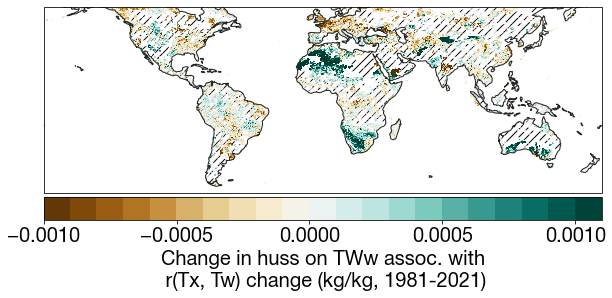

In [797]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.001
v2 = .0011
vstep = .0001
vlabelstep = .0005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = huss_on_tww_chg_from_rtet_da.where(huss_on_tww_chg_from_rtet_p_da.values < 0.05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
density=3

ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, huss_on_tww_chg_from_rtet_p_da.where(huss_on_tww_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in huss on TWw assoc. with\n r(Tx, Tw) change (kg/kg, 1981-2021)', fontsize=20)

plt.savefig('huss_on_tww_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


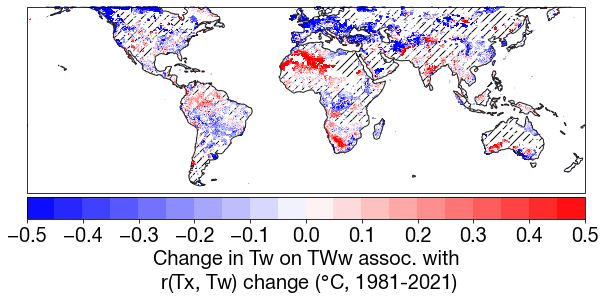

In [454]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tw_on_tww_chg_from_rtet_da.where(tw_on_tww_chg_from_rtet_p_da.values < 0.05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
    
density=3

ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, tw_on_tww_chg_from_rtet_p_da.where(tw_on_tww_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tw on TWw assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

# plt.savefig('tw_on_tww_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


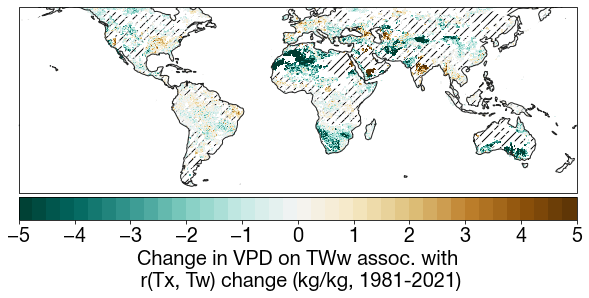

In [128]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -5
v2 = 5.1
vstep = .25
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG_r')

data = vpd_daily_mean_on_tww_chg_from_rtet_da.where(vpd_daily_mean_on_tww_chg_from_rtet_p_da.values < .05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')

density=3

ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, vpd_daily_mean_on_tww_chg_from_rtet_p_da.where(vpd_daily_mean_on_tww_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in VPD on TWw assoc. with\n r(Tx, Tw) change (kg/kg, 1981-2021)', fontsize=20)

# plt.savefig('vpd_daily_mean_on_tww_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


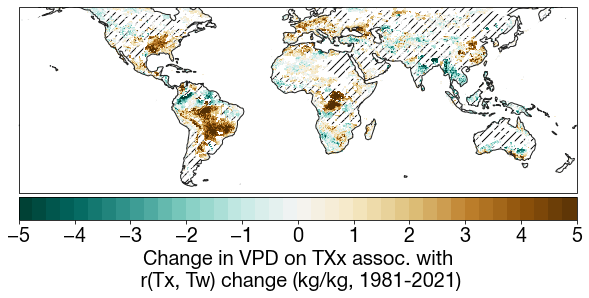

In [39]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -5
v2 = 5.1
vstep = .25
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG_r')

data = vpd_daily_mean_on_txx_chg_from_rtet_da.where(vpd_daily_mean_on_txx_chg_from_rtet_p_da.values < .05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')

density=3

ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, vpd_daily_mean_on_txx_chg_from_rtet_p_da.where(vpd_daily_mean_on_txx_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in VPD on TXx assoc. with\n r(Tx, Tw) change (kg/kg, 1981-2021)', fontsize=20)

plt.savefig('vpd_daily_mean_on_txx_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


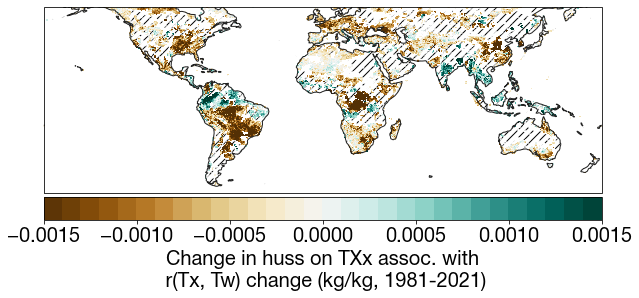

In [796]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.0015
v2 = .00151
vstep = .0001
vlabelstep = .0005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = huss_on_txx_chg_from_rtet_da.where(huss_on_txx_chg_from_rtet_p_da.values < .05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
density=3

ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, huss_on_txx_chg_from_rtet_p_da.where(huss_on_txx_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in huss on TXx assoc. with\n r(Tx, Tw) change (kg/kg, 1981-2021)', fontsize=20)

plt.savefig('huss_on_txx_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


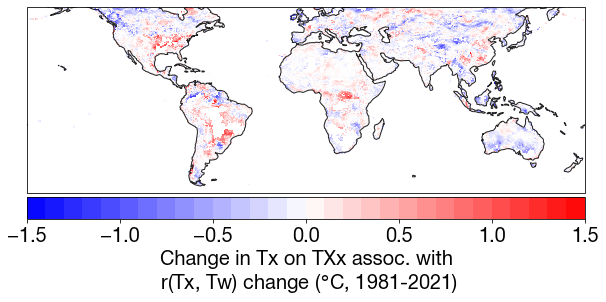

In [455]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tx_on_txx_chg_from_rtet_da.where(tx_on_txx_chg_from_rtet_p_da.values>0.05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tx on TXx assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

# plt.savefig('tx_on_txx_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


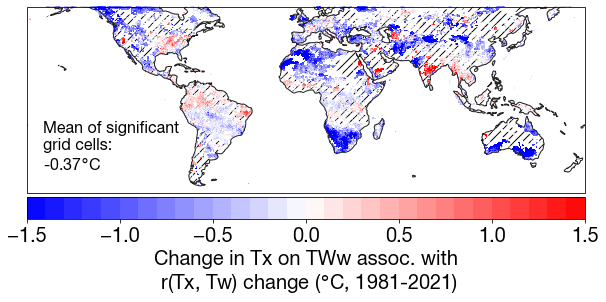

In [72]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tx_on_tww_chg_from_rtet_da.where(tx_on_tww_chg_from_rtet_p_da.values<.05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

plt.text(-170, -30, 'Mean of significant\ngrid cells:\n%.2f$\degree$C'%(xgrid_utils.calc_spatial_mean(data)), fontdict={'size':16}, ha='left', va='center')
    
density=3
ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, tx_on_tww_chg_from_rtet_p_da.where(tx_on_tww_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tx on TWw assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

# plt.savefig('tx_on_tww_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


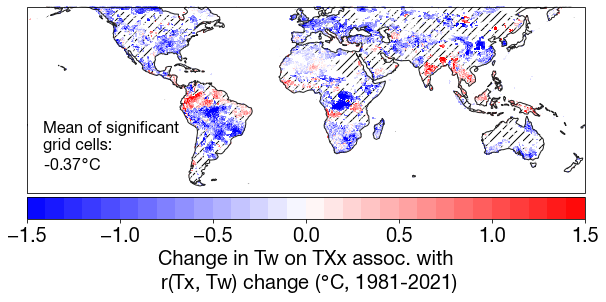

In [77]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tw_on_txx_chg_from_rtet_da.where(tw_on_txx_chg_from_rtet_p_da.values < .05)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

plt.text(-170, -30, 'Mean of significant\ngrid cells:\n%.2f$\degree$C'%(xgrid_utils.calc_spatial_mean(data)), fontdict={'size':16}, ha='left', va='center')

density=3
ax.contourf(
    tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, tw_on_txx_chg_from_rtet_p_da.where(tw_on_txx_chg_from_rtet_p_da.values>=.05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tw on TXx assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

# plt.savefig('tw_on_txx_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [870]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(days_above_tx99.mx2t).values
y_var2 = xgrid_utils.calc_spatial_mean(days_above_tx99.mx2t - n_days_above_tx99_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\n# days above 99th')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.savefig('huss_on_tww_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

ValueError: operands could not be broadcast together with shapes (41,) (0,) 

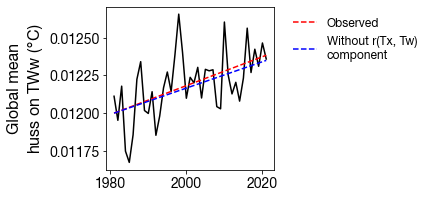

In [527]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(huss_on_tww_full.huss_on_tww).values
y_var2 = xgrid_utils.calc_spatial_mean(huss_on_tww_full.huss_on_tww - huss_on_tww_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nhuss on TWw ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.savefig('huss_on_tww_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

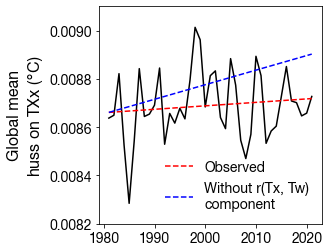

In [169]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(huss_on_txx_full.huss_on_txx).values
y_var2 = xgrid_utils.calc_spatial_mean(huss_on_txx_full.huss_on_txx - huss_on_txx_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(4,4))
plt.plot(x_var, y_var, '-k')
plt.ylim([.0082, .0091])
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nhuss on TXx ($\degree$C)')
font = FontProperties(family='Arial', size=16)
# plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(frameon=False, fontsize=14)
plt.savefig('huss_on_txx_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [42]:
regridder_izumi = xe.Regridder(vpd_daily_mean_on_txx_chg_from_rtet_da.rename({'latitude':'lat', 'longitude':'lon'}), iizumi_maize_ds.sel(lat=slice(60,-60)), 'bilinear', reuse_weights=False)
vpd_daily_mean_on_txx_chg_from_rtet_da_regrid = regridder_izumi(vpd_daily_mean_on_txx_chg_from_rtet_da)

Overwrite existing file: bilinear_481x1440_240x720.nc 
 You can set reuse_weights=True to save computing time.


In [83]:
vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d = np.reshape(vpd_daily_mean_on_txx_chg_from_rtet_da_regrid.values, [vpd_daily_mean_on_txx_chg_from_rtet_da_regrid.values.size])
iizumi_maize_ds_1d = np.reshape(iizumi_maize_ds['var'].sel(lat=slice(60,-60)).mean(dim='time').values, [iizumi_maize_ds['var'].sel(lat=slice(60,-60)).mean(dim='time').values.size])
iizumi_soy_ds_1d = np.reshape(iizumi_soy_ds['var'].sel(lat=slice(60,-60)).mean(dim='time').values, [iizumi_soy_ds['var'].sel(lat=slice(60,-60)).mean(dim='time').values.size])
iizumi_wheat_ds_1d = np.reshape(iizumi_wheat_ds['var'].sel(lat=slice(60,-60)).mean(dim='time').values, [iizumi_wheat_ds['var'].sel(lat=slice(60,-60)).mean(dim='time').values.size])

In [84]:
df = pd.DataFrame({
    'iizumi_maize_ds_1d': iizumi_maize_ds_1d,
    'iizumi_soy_ds_1d': iizumi_soy_ds_1d,
    'iizumi_wheat_ds_1d': iizumi_wheat_ds_1d,
    'vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d': vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d
})

# Calculate deciles for the first variable
df['decile_maize'] = pd.qcut(df['iizumi_maize_ds_1d'], 10, labels=False)
df['decile_soy'] = pd.qcut(df['iizumi_soy_ds_1d'], 10, labels=False)
df['decile_wheat'] = pd.qcut(df['iizumi_wheat_ds_1d'], 10, labels=False)

# Group by deciles and calculate the mean of the second variable
decile_means_maize = df.groupby('decile_maize')['vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d'].mean()
pct_maize = df.groupby('decile_maize')['vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d'].quantile([.25, .75])
decile_means_soy = df.groupby('decile_soy')['vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d'].mean()
pct_soy = df.groupby('decile_soy')['vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d'].quantile([.25, .75])
decile_means_wheat = df.groupby('decile_wheat')['vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d'].mean()
pct_wheat = df.groupby('decile_wheat')['vpd_daily_mean_on_txx_chg_from_rtet_da_regrid_1d'].quantile([.25, .75])


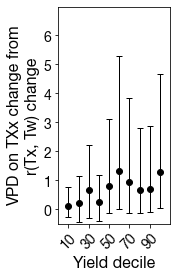

In [588]:
plt.figure(figsize=(2,4))
plt.xlim([-1, 10])
plt.ylim([-.5, 7])

for i in range(10):
    plt.errorbar(i, decile_means_maize[i], yerr=[[decile_means_maize[i]-pct_maize[i][.25]], [decile_means_maize[i]+pct_maize[i][.75]]], fmt='ok', capsize=3, lw=1) 

plt.xticks(np.arange(0,10,2),rotation=45)
plt.yticks(np.arange(0,7,1))
plt.gca().set_xticklabels(np.arange(10,100,20))
plt.xlabel('Yield decile')
plt.ylabel('VPD on TXx change from\nr(Tx, Tw) change')
plt.savefig('vpd_on_txx_chg_by_cf_maize.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

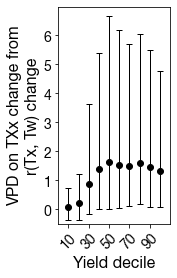

In [589]:
plt.figure(figsize=(2,4))
plt.xlim([-1, 10])
plt.ylim([-.5, 7])

for i in range(10):
    plt.errorbar(i, decile_means_soy[i], yerr=[[decile_means_soy[i]-pct_soy[i][.25]], [decile_means_soy[i]+pct_soy[i][.75]]], fmt='ok', capsize=3, lw=1) 

plt.xticks(np.arange(0,10,2),rotation=45)
plt.yticks(np.arange(0,7,1))
plt.gca().set_xticklabels(np.arange(10,100,20))
plt.xlabel('Yield decile')
plt.ylabel('VPD on TXx change from\nr(Tx, Tw) change')
plt.savefig('vpd_on_txx_chg_by_cf_soy.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

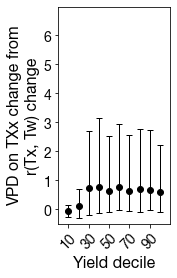

In [590]:
plt.figure(figsize=(2,4))
plt.xlim([-1, 10])
plt.ylim([-.5, 7])

for i in range(10):
    plt.errorbar(i, decile_means_wheat[i], yerr=[[decile_means_wheat[i]-pct_wheat[i][.25]], [decile_means_wheat[i]+pct_wheat[i][.75]]], fmt='ok', capsize=3, lw=1) 

plt.xticks(np.arange(0,10,2),rotation=45)
plt.yticks(np.arange(0,7,1))
plt.gca().set_xticklabels(np.arange(10,100,20))
plt.xlabel('Yield decile')
plt.ylabel('VPD on TXx change from\nr(Tx, Tw) change')
plt.savefig('vpd_on_txx_chg_by_cf_wheat.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [43]:
crop1d = crop_ha_regrid_da.values.reshape([crop_ha_regrid_da.values.size])
vpd1d = vpd_daily_mean_on_txx_chg_from_rtet_da.values.reshape([vpd_daily_mean_on_txx_chg_from_rtet_da.values.size])
n_days_above_txx1d = n_days_above_tx99_chg_from_rtet_da.values.reshape([n_days_above_tx99_chg_from_rtet_da.values.size])
n_days_above_tww1d = n_days_above_tw99_chg_from_rtet_da.values.reshape([n_days_above_tw99_chg_from_rtet_da.values.size])

In [44]:
ssp2_pop = ssp2_pop.sel(lat=slice(60,-60))
ssp2_pop['lon'] = xr.where(ssp2_pop['lon'] < 0, ssp2_pop['lon'] + 360, ssp2_pop['lon'])
ssp2_pop = ssp2_pop.sortby('lon')
ssp2_pop.load();

In [45]:
recalc = False

lonstep = .25
latstep = .25

n_range = np.arange(-5,5.5,1)
n_samples = 50
pop_exp_tx99 = np.full([n_samples, n_range.size, n_days_above_tx99_chg_from_rtet_da.shape[0], n_days_above_tx99_chg_from_rtet_da.shape[1]], np.nan)
pop_exp_tw99 = np.full([n_samples, n_range.size, n_days_above_tx99_chg_from_rtet_da.shape[0], n_days_above_tx99_chg_from_rtet_da.shape[1]], np.nan)

if recalc:
    for xlat in range(n_days_above_tx99_chg_from_rtet_da.shape[0]):
        if xlat%25==0:print(xlat)
        for ylon in range(n_days_above_tx99_chg_from_rtet_da.shape[1]):
            if not lsm[xlat,ylon]: continue
            lat1 = n_days_above_tx99_chg_from_rtet_da[xlat, ylon].latitude.values
            lon1 = n_days_above_tx99_chg_from_rtet_da[xlat, ylon].longitude.values
            lon2 = lon1+lonstep
            lat2 = lat1-latstep

            cur_cell_pop = np.nansum(ssp2_pop.ssp2_2020.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2)).values)
            
            for n in range(n_samples):
#                 n_days_above_tx99_rand = np.random.uniform(n_days_above_tx99_chg_from_rtet_ci_da.values[xlat, ylon, 0], n_days_above_tx99_chg_from_rtet_ci_da.values[xlat, ylon, 1])
                n_days_above_tw99_rand = n_days_above_tw99_chg_from_rtet_rand_da.values[xlat, ylon, n]

                for i in range(n_range.size):
#                     if n_days_above_tx99_rand > n_range[i] and n_days_above_tx99_rand <= n_range[i]+1:
#                         pop_exp_tx99[n, i, xlat, ylon]=cur_cell_pop

                    if n_days_above_tw99_rand > n_range[i] and n_days_above_tw99_rand <= n_range[i]+1:
                        pop_exp_tw99[n, i, xlat, ylon]=cur_cell_pop

            
    with open('pop_exp_tw99.dat', 'wb') as f:
        pickle.dump(pop_exp_tw99, f)
#     with open('pop_exp_tx99.dat', 'wb') as f:
#         pickle.dump(pop_exp_tx99, f)
else:
    with open('pop_exp_tw99.dat', 'rb') as f:
        pop_exp_tw99 = pickle.load(f)
#     with open('pop_exp_tx99.dat', 'rb') as f:
#         pop_exp_tx99 = pickle.load(f)

Text(-3.25, 2.5, 'Decline:\n58.2%')

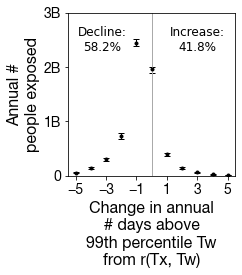

In [59]:
y_pos = np.nanmean(np.nansum(np.nansum(pop_exp_tw99[:,:,:,:],axis=3),axis=2), axis=0)/1e9
err_top = np.nanmax(np.nansum(np.nansum(pop_exp_tw99[:,:,:,:]/1e9,axis=3),axis=2), axis=0) - y_pos
err_bottom = y_pos - np.nanmin(np.nansum(np.nansum(pop_exp_tw99[:,:,:,:]/1e9,axis=3),axis=2), axis=0)

# err_top = np.nanpercentile(np.nansum(np.nansum(pop_exp_tw99[:,:,:,:]/1e9,axis=3),axis=2), axis=0, q=75) - y_pos
# err_bottom = y_pos - np.nanpercentile(np.nansum(np.nansum(pop_exp_tw99[:,:,:,:]/1e9,axis=3),axis=2), axis=0, q=25)

plt.figure(figsize=(3,3))
plt.ylim([0,3])
plt.errorbar(n_range, y_pos, yerr=[err_bottom, err_top], fmt='ok', capsize=3, lw=1, ms=3) 
plt.plot([0, 0],[0,3.5],'-', lw=1, c='#aaaaaa')

plt.xlabel('Change in annual\n# days above\n99th percentile Tw\nfrom r(Tx, Tw)')
plt.ylabel('Annual #\npeople exposed')
plt.xticks([-5,-3,-1,1,3,5])
plt.yticks([0,1,2,3])
plt.gca().set_yticklabels(['0', '1B', '2B', '3B'])

plt.text(3, 2.5, 'Increase:\n%.1f%%'%(100*np.nansum(np.nanmean(pop_exp_tw99[:, 5:,:,:], axis=0))/np.nansum(np.nanmean(pop_exp_tw99, axis=0))), fontdict={'family':'helvetica', 'size':12}, ha='center', va='center')
plt.text(-3.25, 2.5, 'Decline:\n%.1f%%'%(100*np.nansum(np.nanmean(pop_exp_tw99[:, 0:5,:,:], axis=0))/np.nansum(np.nanmean(pop_exp_tw99, axis=0))), fontdict={'family':'helvetica', 'size':12}, ha='center', va='center')
# plt.savefig('pop_exp_tw.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

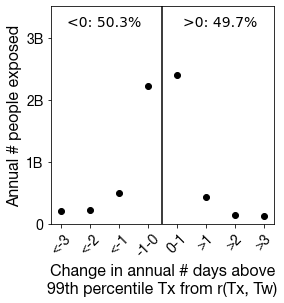

In [597]:
y_pos = np.nanmean(np.nansum(np.nansum(pop_exp_tx99[:,:,:,:],axis=3),axis=2), axis=0)/1e9
err_top = np.nanmax(np.nansum(np.nansum(pop_exp_tx99[:,:,:,:]/1e9,axis=3),axis=2), axis=0) - y_pos
err_bottom = y_pos - np.nanmin(np.nansum(np.nansum(pop_exp_tx99[:,:,:,:]/1e9,axis=3),axis=2), axis=0)

plt.figure(figsize=(4,4))
plt.ylim([0,3])
plt.errorbar(n_range, y_pos, yerr=[err_bottom, err_top], fmt='ok', capsize=3, lw=1, ms=3) 
plt.plot([0, 0],[0,3.5],'-', lw=1, c='#aaaaaa')

plt.xlabel('Change in annual # days above\n99th percentile Tx from r(Tx, Tw)')
plt.xticks(n_range)

plt.yticks([0,1,2,3])
plt.gca().set_yticklabels(['0', '1B', '2B', '3B'])
plt.ylabel('Annual # people exposed')
plt.text(3, 2.5, 'Increase:\n%.1f%%'%(100*np.nansum(np.nanmean(pop_exp_tx99[:, 5:,:,:], axis=0))/np.nansum(np.nanmean(pop_exp_tx99, axis=0))), fontdict={'family':'helvetica', 'size':14}, ha='center', va='center')
plt.text(-3.25, 2.5, 'Decline:\n%.1f%%'%(100*np.nansum(np.nanmean(pop_exp_tx99[:, 0:5,:,:], axis=0))/np.nansum(np.nanmean(pop_exp_tx99, axis=0))), fontdict={'family':'helvetica', 'size':14}, ha='center', va='center')
# plt.savefig('pop_exp_tx.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [205]:
vpd_on_txx_chg = []
vpd_on_txx_chg_p = []
vpd_on_txx_err_top = []
vpd_on_txx_err_bottom = []

n_days_above_txx_chg = []
n_days_above_txx_chg_p = []
n_days_above_txx_err_top = []
n_days_above_txx_err_bottom = []

for ind,i in enumerate(np.arange(0,1,.1)):
    vpd1d_filter = vpd1d[(crop1d>i) & (crop1d<(i+.1))]
    vpd_on_txx_chg.append(np.nanmean(vpd1d_filter))
    nn = np.where(~np.isnan(vpd1d_filter))[0]
    t, p = stats.ttest_1samp(vpd1d_filter[nn], 0)
    vpd_on_txx_chg_p.append(p)
    vpd_on_txx_err_top.append(np.nanpercentile(vpd1d_filter, 75)-vpd_on_txx_chg[ind])
    vpd_on_txx_err_bottom.append(vpd_on_txx_chg[ind]-np.nanpercentile(vpd1d_filter, 25))
    
    n_days_above_txx1d_filter = n_days_above_txx1d[(crop1d>i) & (crop1d<(i+.1))]
    n_days_above_txx_chg.append(np.nanmean(n_days_above_txx1d_filter))
    nn = np.where(~np.isnan(n_days_above_txx1d_filter))[0]
    t, p = stats.ttest_1samp(n_days_above_txx1d_filter[nn], 0)
    n_days_above_txx_chg_p.append(p)
    n_days_above_txx_err_top.append(np.nanpercentile(n_days_above_txx1d_filter, 75)-n_days_above_txx_chg[ind])
    n_days_above_txx_err_bottom.append(n_days_above_txx_chg[ind]-np.nanpercentile(n_days_above_txx1d_filter, 25))
    
vpd_on_txx_yerr = [vpd_on_txx_err_bottom, vpd_on_txx_err_top]
n_days_above_txx_yerr = [n_days_above_txx_err_bottom, n_days_above_txx_err_top]


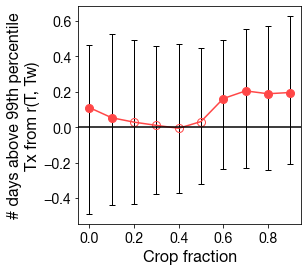

In [277]:
plt.figure(figsize=(4,4))
plt.xlim([-.05,.95])
plt.plot(np.arange(0,1,.1), n_days_above_txx_chg, c='#ff4747')
for ind, i in enumerate(np.arange(0, 1, 0.1)):
    if n_days_above_txx_chg_p[ind] < .05:
        plt.plot(i, n_days_above_txx_chg[ind], 'ok', ms=8, c='#ff4747')
    else:
        plt.plot(i, n_days_above_txx_chg[ind], 'ok', ms=8, mfc='none', c='#ff4747')

plt.errorbar(np.arange(0, 1, 0.1), n_days_above_txx_chg, yerr=n_days_above_txx_yerr, fmt='none', color='k', capsize=3, lw=1, mfc='none') 
plt.plot([-.05,.95], [0,0], '-k')
plt.ylabel('# days above 99th percentile\nTx from r(T, Tw)')
plt.xlabel('Crop fraction')
plt.xticks(np.arange(0,1,.2))
plt.savefig('n_days_above_tx99_by_cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

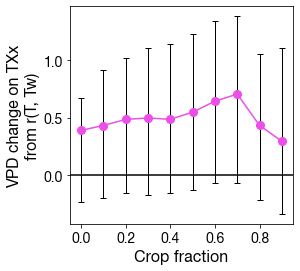

In [280]:
plt.figure(figsize=(4,4))
plt.xlim([-.05,.95])
plt.plot(np.arange(0,1,.1), vpd_on_txx_chg, c='#ed4ee8')
for ind, i in enumerate(np.arange(0, 1, 0.1)):
    if vpd_on_txx_chg_p[ind] < .05:
        plt.plot(i, vpd_on_txx_chg[ind], 'ok', ms=8, c='#ed4ee8')
    else:
        plt.plot(i, vpd_on_txx_chg[ind], 'ok', ms=8, mfc='none', c='#ed4ee8')

plt.errorbar(np.arange(0, 1, 0.1), vpd_on_txx_chg, yerr=vpd_on_txx_yerr, fmt='none', color='k', capsize=3, lw=1, mfc='none') 
plt.plot([-.05,.95], [0,0], '-k')
plt.ylabel('VPD change on TXx\nfrom r(T, Tw)')
plt.xlabel('Crop fraction')
plt.savefig('vpd_on_txx_chg_by_cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [462]:
tw_ext_sig = []
tw_ext_cnt_conterfac = []
tw_ext_cnt_obs = []
step = 1
tw_ext_t_range = np.arange(11,36,step)

tw_1d = tw_on_tw_full['tw_on_tww'].values.reshape([tw_on_tw_full['tw_on_tww'].values.size])
tw_from_rtet_1d = tw_on_tww_from_rtet_da.values.reshape([tw_on_tww_from_rtet_da.values.size])

tw_days_chg_from_rtet_spatial = np.full([tw_ext_t_range.size, tw_days_chg_from_rtet_spatial.shape[1], tw_days_chg_from_rtet_spatial.shape[2]], np.nan)

for t_ind,t in enumerate(tw_ext_t_range):
    print(t)
    ind = np.where((tw_1d >= t) & (tw_1d < t+step))[0]
    v1 = tw_1d[ind]
    v2 = tw_1d[ind] + tw_from_rtet_1d[ind]
    
    tw_days_chg_from_rtet_spatial[t_ind, :, :] = np.sum(np.where((tw_on_tw_full['tw_on_tww'].values >= t) & (tw_on_tw_full['tw_on_tww'].values < t+step), 1, 0) - \
                                                            np.where((tw_on_tw_full['tw_on_tww'].values-tw_on_tww_from_rtet_da.values >= t) & (tw_on_tw_full['tw_on_tww'].values-tw_on_tww_from_rtet_da.values < t+step), 1, 0), axis=0)
    
    obs_values = tw_on_tw_full['tw_on_tww'].values[(tw_on_tw_full['tw_on_tww'].values>=t) & (tw_on_tw_full['tw_on_tww'].values < t+step)]
    counterfac_vals = (tw_on_tw_full['tw_on_tww'] - tw_on_tww_from_rtet_da).values[((tw_on_tw_full['tw_on_tww'] - tw_on_tww_from_rtet_da).values >= t) & ((tw_on_tw_full['tw_on_tww'] - tw_on_tww_from_rtet_da).values < t+step)]
    
    tw_ext_cnt_conterfac.append(counterfac_vals.size)
    tw_ext_cnt_obs.append(obs_values.size)
    
    if v1.size > 0 and v2.size > 0:
        t_stat, p_value = stats.ks_2samp(v1, v2)
        tw_ext_sig.append(p_value)
    else:
        tw_ext_sig.append(np.nan)

tw_ext_cnt_conterfac = np.array(tw_ext_cnt_conterfac)
tw_ext_cnt_obs = np.array(tw_ext_cnt_obs)
tw_ext_sig = np.array(tw_ext_sig)

# tx_ext_cnt_conterfac = []
# tx_ext_cnt_obs = []
# tx_ext_t_range = np.arange(20,53)
# for t in tx_ext_t_range:
#     tx_ext_cnt_conterfac.append((tx_on_tx_full['tx_on_txx'] - tx_on_txx_from_rtet_da).values[((tx_on_tx_full['tx_on_txx'] - tx_on_txx_from_rtet_da).values>=t) & ((tx_on_tx_full['tx_on_txx'] - tx_on_txx_from_rtet_da).values<t+1)].size)
#     tx_ext_cnt_obs.append(tx_on_tx_full['tx_on_txx'].values[(tx_on_tx_full['tx_on_txx'].values>=t) & (tx_on_tx_full['tx_on_txx'].values < t+1)].size)

# tx_ext_cnt_conterfac = np.array(tx_ext_cnt_conterfac)
# tx_ext_cnt_obs = np.array(tx_ext_cnt_obs)

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [468]:
recalc = True

lonstep = .25
latstep = .25

tw_days_above_27_spatial = np.nansum(tw_days_chg_from_rtet_spatial, axis=0)

pop_exp_tw27 = np.full([n_days_above_tx99_chg_from_rtet_da.shape[0], n_days_above_tx99_chg_from_rtet_da.shape[1]], np.nan)

if recalc:
    for xlat in range(n_days_above_tx99_chg_from_rtet_da.shape[0]):
        if xlat%25==0:print(xlat)
        for ylon in range(n_days_above_tx99_chg_from_rtet_da.shape[1]):
            if not lsm[xlat,ylon]: continue
            lat1 = n_days_above_tx99_chg_from_rtet_da[xlat, ylon].latitude.values
            lon1 = n_days_above_tx99_chg_from_rtet_da[xlat, ylon].longitude.values
            lon2 = lon1+lonstep
            lat2 = lat1-latstep

            cur_cell_pop = np.nansum(ssp2_pop.ssp2_2020.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2)).values)
            
            if tw_days_above_27_spatial[xlat, ylon] > 0:
                pop_exp_tw27[xlat, ylon] = cur_cell_pop
            elif tw_days_above_27_spatial[xlat, ylon] < 0:
                pop_exp_tw27[xlat, ylon] = -cur_cell_pop
            

            
#     with open('pop_exp_tw99.dat', 'wb') as f:
#         pickle.dump(pop_exp_tw99, f)
# #     with open('pop_exp_tx99.dat', 'wb') as f:
# #         pickle.dump(pop_exp_tx99, f)
# else:
#     with open('pop_exp_tw99.dat', 'rb') as f:
#         pop_exp_tw99 = pickle.load(f)
# #     with open('pop_exp_tx99.dat', 'rb') as f:
# #         pop_exp_tx99 = pickle.load(f)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


In [473]:
np.nansum(pop_exp_tw27[pop_exp_tw27<0])

-3152330.0

In [472]:
np.nansum(pop_exp_tw27[pop_exp_tw27>0])

2452064.0

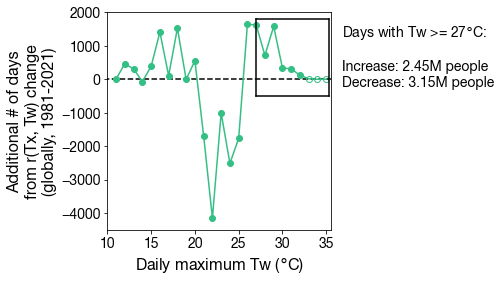

In [499]:
plt.figure(figsize=(4,4))
plt.ylim([-4500,2000])
plt.xlim([10,35.5])

# Plotting the difference between two arrays
plt.plot([tw_ext_t_range[0]-5, tw_ext_t_range[-1]+5], [0,0], '--k')
plt.plot(tw_ext_t_range, tw_ext_cnt_obs-tw_ext_cnt_conterfac, '-', c='#34bf85')

for i, value in enumerate(tw_ext_cnt_obs - tw_ext_cnt_conterfac):
    
    if tw_ext_sig[i] < .05:
        plt.plot(tw_ext_t_range[i], value, 'o', c='#34bf85')
    else:
        plt.plot(tw_ext_t_range[i], value, 'o', mfc='none', c='#34bf85')
#     if tw_ext_t_range[i] > 45:
#         plt.text(tw_ext_t_range[i], value+150, str(value), ha='center', va='bottom', fontsize=14, rotation=20)
#     else:
#         plt.text(tw_ext_t_range[i]+.2, value+150, str(value), ha='center', va='bottom', fontsize=14, rotation=20)

# plt.axvspan(11, 20, color='pink', alpha=0.3)  # You can adjust the color and alpha for different shading
# plt.fill_between([10,20], 0, 2000, color='pink', alpha=0.3)
# plt.fill_between([20,26], -4500, 0, color='lightblue', alpha=0.3)
# plt.fill_between([26,35], 0, 2000, color='pink', alpha=0.3)

# Drawing a box around the values between 27°C and 35°C
plt.plot([27, 27], [-500, 1800], 'k')  # Left vertical line
plt.plot([35.3, 35.3], [-500, 1800], 'k')  # Right vertical line
plt.plot([27, 35.3], [-500, -500], 'k')  # Bottom horizontal line
plt.plot([27, 35.3], [1800, 1800], 'k')  # Top horizontal line

textstr = 'Days with Tw >= 27$\degree$C:\n\nIncrease: 2.45M people\nDecrease: 3.15M people'
plt.text(1.05, .95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top')

plt.ylabel('Additional # of days\nfrom r(Tx, Tw) change\n(globally, 1981-2021)')
plt.xlabel('Daily maximum Tw ($\degree$C)')
plt.xticks(np.arange(10,35+1, 5))
plt.savefig('tw_dist_chg_from_rtet.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

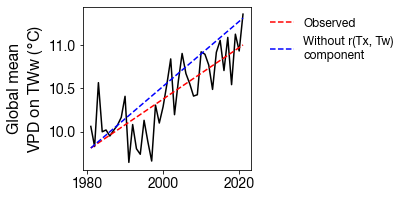

In [130]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(vpd_daily_mean_on_tww_full.vpd_daily_mean_on_tww).values
y_var2 = xgrid_utils.calc_spatial_mean(vpd_daily_mean_on_tww_full.vpd_daily_mean_on_tww - vpd_daily_mean_on_tww_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nVPD on TWw ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('vpd_daily_mean_on_tww_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

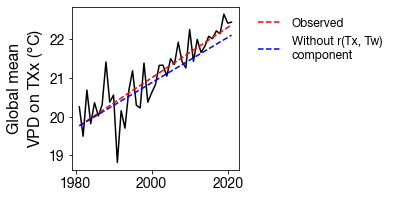

In [55]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(vpd_daily_mean_on_txx_full.vpd_daily_mean_on_txx).values
y_var2 = xgrid_utils.calc_spatial_mean(vpd_daily_mean_on_txx_full.vpd_daily_mean_on_txx - vpd_daily_mean_on_txx_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nVPD on TXx ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('vpd_daily_mean_on_txx_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

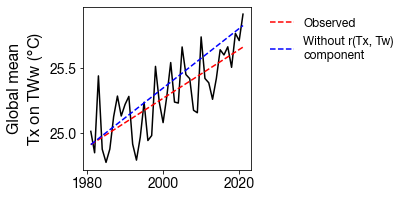

In [133]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(tx_on_tw_full.tx_on_tww).values
y_var2 = xgrid_utils.calc_spatial_mean(tx_on_tw_full.tx_on_tww - tx_on_tww_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nTx on TWw ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('tx_on_tww_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

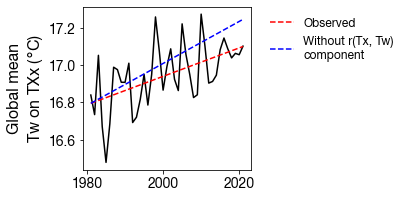

In [132]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(tw_on_tx_full.tw_on_txx).values
y_var2 = xgrid_utils.calc_spatial_mean(tw_on_tx_full.tw_on_txx - tw_on_txx_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nTw on TXx ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('tw_on_txx_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

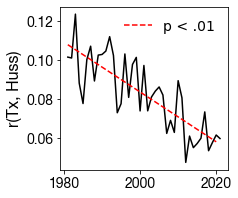

In [324]:
x_var = tx_huss_corr_ts.tx_huss_corr.time.dt.year.values
y_var = tx_huss_corr_ts.tx_huss_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Huss)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('r(tx,huss)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

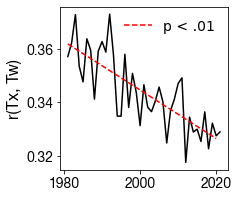

In [12]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = tx_tw_corr_ts.tx_tw_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Tw)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('r(tx,tw)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [491]:
#CALC ERA5 GLOBAL MEAN TX TIME SERIES
recalc = False
if recalc:
    tx_era5 = xr.open_mfdataset('%s/daily/tasmax_*.nc'%dirEra5)
    tx_era5 = tx_era5.sel(time=slice('1981', '2021')).sel(latitude=slice(60, -60))
    tx_era5['mx2t'] -= 273.15
    tx_era5 = tx_era5.where(land_sea_mask_binary)
    tx_era5_annual = tx_era5.mx2t.resample(time='Y').mean()
    tx_era5_ts = xgrid_utils.calc_spatial_mean(tx_era5_annual)
    tx_era5_ts.to_netcdf('era5_global_mean_tx_ts.nc')
    tx_era5_annual.to_netcdf('era5_global_mean_tx_annual.nc')
else:
    tx_era5_ts = xr.open_dataset('era5_global_mean_tx_ts.nc')
    tx_era5_annual = xr.open_dataset('era5_global_mean_tx_annual.nc')


In [492]:
# r_tx_tw_per_deg = np.full([tx_era5_annual.latitude.size, tx_era5_annual.longitude.size],np.nan)
# r_tx_tw_per_gmt_deg = np.full([tx_era5_annual.latitude.size, tx_era5_annual.longitude.size],np.nan)

# cur_tx_gmt = tx_era5_ts.mx2t[:].values
# cur_tx_gmt_detrend = signal.detrend(cur_tx_gmt)

# for xlat in range(tx_era5_annual.latitude.size):
#     if xlat % 25 == 0: print(xlat)
#     for ylon in range(tx_era5_annual.longitude.size):
        
#         cur_tx_tw_corr = tx_tw_corr_full.tx_tw_corr[:,xlat,ylon].values
#         cur_tx = tx_era5_annual.mx2t[:,xlat,ylon].values
        
#         nn = np.where((~np.isnan(cur_tx_tw_corr)) & (~np.isnan(cur_tx)))[0]
        
#         if nn.size > 20:

#             cur_tx_tw_corr_detrend = signal.detrend(cur_tx_tw_corr[nn])
#             cur_tx_detrend = signal.detrend(cur_tx[nn])
        
#             X = sm.add_constant(cur_tx_detrend)
#             mdl = sm.OLS(cur_tx_tw_corr_detrend,X).fit()
#             r_tx_tw_per_deg[xlat, ylon] = mdl.params[1]
            
#             X = sm.add_constant(cur_tx_gmt_detrend)
#             mdl = sm.OLS(cur_tx_tw_corr_detrend,X).fit()
#             r_tx_tw_per_gmt_deg[xlat, ylon] = mdl.params[1]
# with open('era5_r_tx_tw_per_deg.dat', 'wb') as f:
#     pickle.dump(r_tx_tw_per_deg, f)
# with open('era5_r_tx_tw_per_gmt_deg.dat', 'wb') as f:
#     pickle.dump(r_tx_tw_per_gmt_deg, f)

In [74]:
tw_era5_mean = xr.open_dataset('era5_tw_max_mean.nc')
tw_era5_mean.load()
tw_era5_mean['tw'] = tw_era5_mean['tw'].where(land_sea_mask_binary, np.nan)
tw_era5_mean['tw'] = tw_era5_mean['tw'].sel(latitude=slice(60,-60))

tx_era5_mean = xr.open_dataset('era5_tasmax_mean.nc')
tx_era5_mean.load()
tx_era5_mean['mx2t'] -= 273.15

huss_era5_mean = xr.open_dataset('era5_huss_mean.nc')
huss_era5_mean.load()

sm_era5_mean = xr.open_dataset('era5_sm_mean_regrid.nc')
sm_era5_mean['swvl1'] = sm_era5_mean['swvl1'].sel(latitude=slice(60,-60))
sm_era5_mean.load();



In [75]:
tx_tw_corr_trend = xr.open_dataset('era5_tx_tw_corr_warm_season_trend.nc')
tx_tw_corr_trend.load()
tx_tw_corr_trend = tx_tw_corr_trend.sel(latitude=slice(60,-60))

tx_huss_corr_trend = xr.open_dataset('era5_tx_huss_corr_warm_season_trends.nc')
tx_huss_corr_trend.load()
tx_huss_corr_trend = tx_huss_corr_trend.sel(latitude=slice(60,-60))

In [76]:
tp_on_tx_trend = xr.open_dataset('era5_tp_on_tx_warm_season_trend.nc')
tp_on_tx_trend.load()
tp_on_tx_trend = tp_on_tx_trend.sel(latitude=slice(60,-60))

tp_on_tw_trend = xr.open_dataset('era5_tp_on_tw_warm_season_trend.nc')
tp_on_tw_trend.load()
tp_on_tw_trend['tp_on_tw_warm_season_trend'] = tp_on_tw_trend['tp_on_tw_warm_season_trend'].sel(latitude=slice(60,-60))
tp_on_tw_trend['tp_on_tw_warm_season_p_value'] = tp_on_tw_trend['tp_on_tw_warm_season_p_value'].sel(latitude=slice(60,-60))

In [77]:
huss_on_txx_trend = xr.open_dataset('era5_huss_on_txx_trends.nc')
huss_on_txx_trend.load()
huss_on_txx_trend = huss_on_txx_trend.sel(latitude=slice(60,-60))

huss_on_tx_season_trend = xr.open_dataset('era5_huss_on_tx_season_trends.nc')
huss_on_tx_season_trend.load()
huss_on_tx_season_trend = huss_on_tx_season_trend.sel(latitude=slice(60,-60))

huss_on_tww_trend = xr.open_dataset('era5_huss_on_tww_trends.nc')
huss_on_tww_trend.load()
huss_on_tww_trend = huss_on_tww_trend.sel(latitude=slice(60,-60))

In [78]:
vpd_on_txx_trend = xr.open_dataset('era5_vpd_daily_mean_on_txx_trends.nc')
vpd_on_txx_trend.load()
vpd_on_txx_trend = vpd_on_txx_trend.sel(latitude=slice(60,-60))


vpd_on_tww_trend = xr.open_dataset('era5_vpd_daily_mean_on_tww_trends.nc')
vpd_on_tww_trend.load()
vpd_on_tww_trend = vpd_on_tww_trend.sel(latitude=slice(60,-60))


In [121]:
evap_on_txx_trend = xr.open_dataset('era5_evap_on_txx_trends.nc')
evap_on_txx_trend.load()
evap_on_txx_trend = evap_on_txx_trend.sel(latitude=slice(60,-60))
evap_on_txx_trend['evap_on_txx_trend'] *= -1

evap_on_tx_season_trend = xr.open_dataset('era5_evap_on_tx_season_trends.nc')
evap_on_tx_season_trend.load()
evap_on_tx_season_trend['evap_on_tx_season_trend'] = evap_on_tx_season_trend['evap_on_tx_season_trend'].sel(latitude=slice(60,-60))
evap_on_tx_season_trend['evap_on_tx_season_trend'] *= -1

evap_on_tww_trend = xr.open_dataset('era5_evap_on_tww_trends.nc')
evap_on_tww_trend.load()
evap_on_tww_trend = evap_on_tww_trend.sel(latitude=slice(60,-60))
evap_on_tww_trend['evap_on_tww_trend'] *= -1

In [122]:

tw_on_tww_trend = xr.open_dataset('era5_tw_on_tww_trends.nc')
tw_on_tww_trend.load()
tw_on_tww_trend = tw_on_tww_trend.sel(latitude=slice(60,-60))

tx_on_txx_trend = xr.open_dataset('era5_tx_on_txx_trends.nc')
tx_on_txx_trend.load()
tx_on_txx_trend = tx_on_txx_trend.sel(latitude=slice(60,-60))


In [90]:
# tw_on_tx_trend = xr.open_dataset('era5_tw_on_warm_season_tx_trends_by_decile_new.nc')
# tw_on_tx_trend.load()
# tw_on_tx_trend['tw_on_warm_season_tx_trend'] = tw_on_tx_trend['tw_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
# tw_on_tx_trend['tw_on_warm_season_tx_p_value'] = tw_on_tx_trend['tw_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

tw_on_txx_trend = xr.open_dataset('era5_tw_on_txx_trends.nc')
tw_on_txx_trend.load()
tw_on_txx_trend = tw_on_txx_trend.sel(latitude=slice(60,-60))

tx_on_tww_trend = xr.open_dataset('era5_tx_on_tww_trends.nc')
tx_on_tww_trend.load()
tx_on_tww_trend = tx_on_tww_trend.sel(latitude=slice(60,-60))

tw_on_tww_trend = xr.open_dataset('era5_tw_on_tww_trends.nc')
tw_on_tww_trend.load()
tw_on_tww_trend = tw_on_tww_trend.sel(latitude=slice(60,-60))


tw_on_txx_minus_tw_on_tww_trend = xr.open_dataset('era5_tw_on_txx_minus_tw_on_tww_trends.nc')
tw_on_txx_minus_tw_on_tww_trend.load()
tw_on_txx_minus_tw_on_tww_trend = tw_on_txx_minus_tw_on_tww_trend.sel(latitude=slice(60,-60))

tx_on_tww_minus_tx_on_txx_trend = xr.open_dataset('era5_tx_on_tww_minus_tx_on_txx_trends.nc')
tx_on_tww_minus_tx_on_txx_trend.load()
tx_on_tww_minus_tx_on_txx_trend = tx_on_tww_minus_tx_on_txx_trend.sel(latitude=slice(60,-60))

# tx_on_tw_trend = xr.open_dataset('era5_tx_on_warm_season_tw_trends_by_decile_new.nc')
# tx_on_tw_trend.load()
# tx_on_tw_trend['tx_on_warm_season_tw_trend'] = tx_on_tw_trend['tx_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
# tx_on_tw_trend['tx_on_warm_season_tw_p_value'] = tx_on_tw_trend['tx_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

In [124]:
sm_on_tx_trends = xr.open_dataset('era5_sm_on_warm_season_tx_trends_by_decile_new.nc')
sm_on_tx_trends.load()
sm_on_tx_trends['sm_on_warm_season_tx_trend'] = sm_on_tx_trends['sm_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
sm_on_tx_trends['sm_on_warm_season_tx_p_value'] = sm_on_tx_trends['sm_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

sm_on_tw_trends = xr.open_dataset('era5_sm_on_warm_season_tw_trends_by_decile_new.nc')
sm_on_tw_trends.load()
sm_on_tw_trends['sm_on_warm_season_tw_trend'] = sm_on_tw_trends['sm_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
sm_on_tw_trends['sm_on_warm_season_tw_p_value'] = sm_on_tw_trends['sm_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

In [233]:
rtet_trend_1d = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape([tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size])*10
vpd_chg_1d = vpd_on_txx_trend['vpd_daily_mean_on_txx_trend'].values.reshape([vpd_on_txx_trend['vpd_daily_mean_on_txx_trend'].values.size])*(2021-1981+1)

rtet_trend_by_cf = []
rtet_trend_by_cf_err_bottom = []
rtet_trend_by_cf_err_top = []

vpd_chg_by_cf = []
vpd_chg_by_cf_p = []
vpd_chg_by_cf_err_bottom = []
vpd_chg_by_cf_err_top = []

for ind,i in enumerate(np.arange(0,1,.1)):
    rtet_trend_by_cf.append(np.nanmean(rtet_trend_1d[(crop1d>i) & (crop1d<(i+.1))]))
    
    vpd_bg_trend_filter_1d = vpd_chg_1d[(crop1d>i) & (crop1d<(i+.1))]
    
    nn = np.where(~np.isnan(vpd_bg_trend_filter_1d))[0]
    t, p = stats.ttest_1samp(vpd_bg_trend_filter_1d[nn], 0)
    vpd_chg_by_cf_p.append(p)
    
    vpd_chg_by_cf.append(np.nanmean(vpd_bg_trend_filter_1d))
    vpd_chg_by_cf_err_top.append(np.nanpercentile(vpd_bg_trend_filter_1d, 60)-vpd_chg_by_cf[ind])
    vpd_chg_by_cf_err_bottom.append(vpd_chg_by_cf[ind]-np.nanpercentile(vpd_bg_trend_filter_1d, 40))
    
    
    rtet_trend_by_cf_err_top.append(np.nanpercentile(rtet_trend_1d[(crop1d>i) & (crop1d<(i+.1))], 75)-rtet_trend_by_cf[ind])
    rtet_trend_by_cf_err_bottom.append(rtet_trend_by_cf[ind]-np.nanpercentile(rtet_trend_1d[(crop1d>i) & (crop1d<(i+.1))], 25))
    


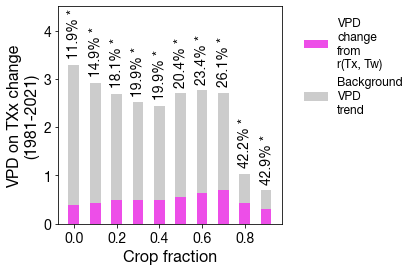

In [290]:
vpd_on_txx_chg = np.array(vpd_on_txx_chg)
vpd_chg_by_cf = np.array(vpd_chg_by_cf)
indices = np.arange(0,1,.1)
bar_width=.05

plt.figure(figsize=(4, 4))
plt.ylim([0,4.5])

# Plot the stacked bars
plt.bar(indices, vpd_on_txx_chg, bar_width, label='VPD\nchange\nfrom\nr(Tx, Tw)', facecolor='#ed4ee8')
plt.bar(indices, vpd_chg_by_cf - vpd_on_txx_chg, bar_width, bottom=vpd_on_txx_chg, label='Background\nVPD\ntrend', facecolor='#cccccc')
# plt.errorbar(indices, vpd_chg_by_cf, yerr=[vpd_chg_by_cf_err_bottom, vpd_chg_by_cf_err_top], fmt='ok', capsize=3, lw=1, ms=7) 

# Calculate and add percentage on top of the bars
for i in range(vpd_on_txx_chg.size):
    percentage = (vpd_on_txx_chg[i]) / vpd_chg_by_cf[i] * 100
    
    if vpd_chg_by_cf_p[i] < .05:
        plt.text(indices[i], vpd_chg_by_cf[i] + 0.2, f'{percentage:.1f}% *', ha='center', fontsize=14, rotation=90)
    else:
        plt.text(indices[i], vpd_chg_by_cf[i] + 0.2, f'{percentage:.1f}% *', ha='center', fontsize=14, rotation=90)

# Add labels and title
plt.xlabel('Crop fraction')
plt.xticks(np.arange(0,1,.2))
plt.ylabel('VPD on TXx change\n(1981-2021)')

# Add legend
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('background-vpd-vs-rtet-bar.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

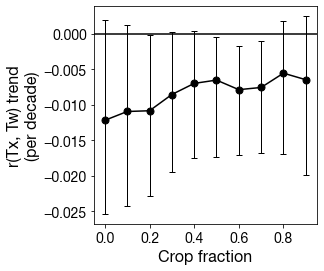

In [286]:
plt.figure(figsize=(4,4))
plt.xlim([-.05,.95])
plt.plot(np.arange(0, 1, 0.1), rtet_trend_by_cf, c='k')
plt.errorbar(np.arange(0, 1, 0.1), rtet_trend_by_cf, yerr=[rtet_trend_by_cf_err_bottom, rtet_trend_by_cf_err_top], fmt='ok', capsize=3, lw=1, ms=7, ecolor='k') 
plt.plot([-.05,.95], [0,0], '-k')
plt.ylabel('r(Tx, Tw) trend\n(per decade)')
plt.xlabel('Crop fraction')
plt.xticks(np.arange(0,1,.2))
plt.savefig('rtet_trend_by_cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

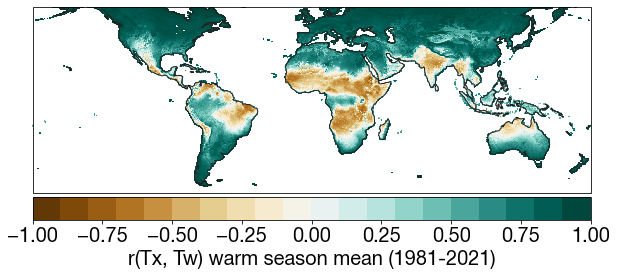

In [518]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_mean.tx_tw_corr

masked_data = data.where(land_sea_mask_binary)

c = plt.pcolormesh(masked_data.longitude, masked_data.latitude, masked_data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw) warm season mean (1981-2021)', fontsize=20)

plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



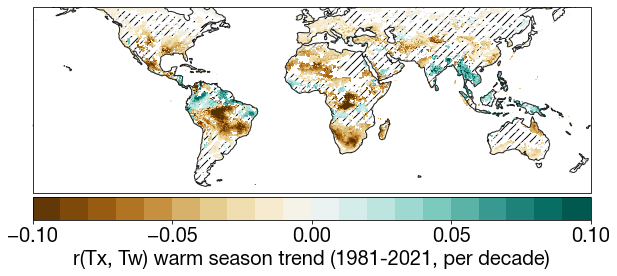

In [515]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_trend.tx_tw_corr_warm_season_trend*10
p_val = tx_tw_corr_trend.tx_tw_corr_warm_season_p_value

mask = p_val < 0.05
masked_data = data.where(mask)

c = plt.pcolormesh(masked_data.longitude, masked_data.latitude, masked_data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-135, -30, 'Mean: %.3f\n/decade'%(xgrid_utils.calc_spatial_mean(masked_data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')

density=3

ax.contourf(
    masked_data.longitude, masked_data.latitude, p_val.where(p_val.values >= .05),
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=[density*'/',density*'/'],
)

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw) warm season trend (1981-2021, per decade)', fontsize=20)

plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



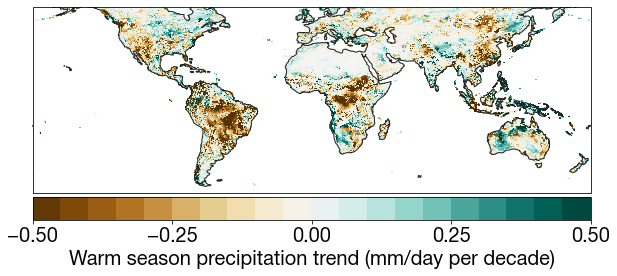

In [130]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = era5_monthly_tp_trend_max_r2*10*1000

c = plt.pcolormesh(lon, tp_on_tx_trend.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Warm season precipitation trend (mm/day per decade)', fontsize=20)

# plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



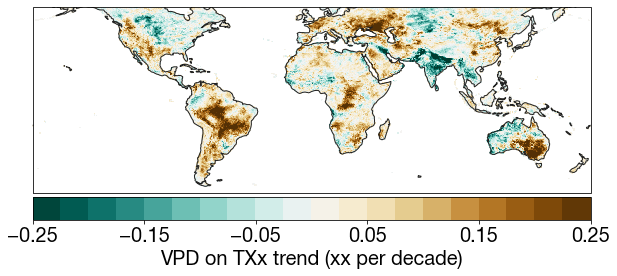

In [72]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG_r')

data = vpd_on_txx_trend['vpd_daily_mean_on_txx_trend'].sel(latitude=slice(60,-60))

c = plt.pcolormesh(lon, vpd_on_txx_trend.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('VPD on TXx trend (xx per decade)', fontsize=20)

# plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



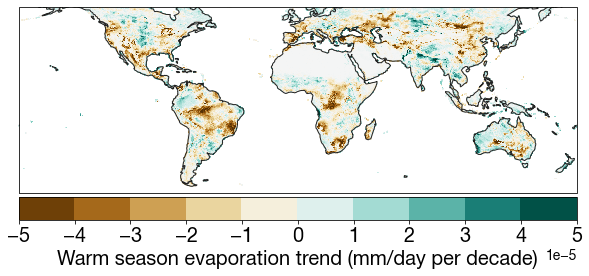

In [46]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -5e-5
v2 = 5.01e-5
vstep = 1e-5
vlabelstep = 1e-5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = evap_on_tx_trend['evaporation_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60))

c = plt.pcolormesh(lon, tp_on_tx_trend.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Warm season evaporation trend (mm/day per decade)', fontsize=20)

# plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



In [243]:
tx_tw_corr_trend_1d = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.sel(latitude=slice(60,-60)).values.reshape([tx_tw_corr_trend.tx_tw_corr_warm_season_trend.sel(latitude=slice(60,-60)).values.size])*10
era5_monthly_tp_trend_max_r2_1d = era5_monthly_tp_trend_max_r2.reshape([era5_monthly_tp_trend_max_r2.size])

use_tx = False

if use_tx:
    era5_evap_trend_1d = evap_on_txx_trend['evap_on_txx_trend'].sel(latitude=slice(60,-60)).values.reshape([evap_on_txx_trend['evap_on_txx_trend'].sel(latitude=slice(60,-60)).values.size])
    era5_vpd_trend_1d = -vpd_on_txx_trend['vpd_daily_mean_on_txx_trend'].sel(latitude=slice(60,-60)).values.reshape([vpd_on_txx_trend['vpd_daily_mean_on_txx_trend'].sel(latitude=slice(60,-60)).values.size])
#     era5_evap_trend_1d = evap_on_tx_season_trend['evap_on_tx_season_trend'].sel(latitude=slice(60,-60)).values.reshape([evap_on_tx_season_trend['evap_on_tx_season_trend'].sel(latitude=slice(60,-60)).values.size])
    
    era5_sm_trend_1d = sm_on_tx_trends['sm_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([sm_on_tx_trends['sm_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
#     era5_huss_trend_1d = huss_on_tx_season_trend['huss_on_tx_season_trend'].sel(latitude=slice(60,-60)).values.reshape([huss_on_tx_season_trend['huss_on_tx_season_trend'].sel(latitude=slice(60,-60)).values.size])
    era5_huss_trend_1d = huss_on_txx_trend['huss_on_txx_trend'].sel(latitude=slice(60,-60)).values.reshape([huss_on_txx_trend['huss_on_txx_trend'].sel(latitude=slice(60,-60)).values.size])
else:
#     era5_evap_trend_1d = evap_on_tw_trend['evaporation_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([evap_on_tw_trend['evaporation_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
    era5_evap_trend_1d = evap_on_tww_trend['evap_on_tww_trend'].sel(latitude=slice(60,-60)).values.reshape([evap_on_tww_trend['evap_on_tww_trend'].sel(latitude=slice(60,-60)).values.size])
    era5_vpd_trend_1d = -vpd_on_tww_trend['vpd_daily_mean_on_tww_trend'].sel(latitude=slice(60,-60)).values.reshape([vpd_on_tww_trend['vpd_daily_mean_on_tww_trend'].sel(latitude=slice(60,-60)).values.size])
    era5_sm_trend_1d = sm_on_tw_trends['sm_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([sm_on_tw_trends['sm_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
#     era5_huss_trend_1d = huss_on_tw_trend['huss_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([huss_on_tw_trend['huss_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
    era5_huss_trend_1d = huss_on_tww_trend['huss_on_tww_trend'].sel(latitude=slice(60,-60)).values.reshape([huss_on_tww_trend['huss_on_tww_trend'].sel(latitude=slice(60,-60)).values.size])
    

    

In [244]:
tx_tw_corr_trend_percentile_levels = np.nanpercentile(tx_tw_corr_trend_1d, np.arange(1,99))
abs_diff = np.abs(tx_tw_corr_trend_1d[:, np.newaxis] - tx_tw_corr_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
tx_tw_corr_trend_percentiles_1d = min_diff_indices.astype(float)
tx_tw_corr_trend_percentiles_1d[tx_tw_corr_trend_percentiles_1d == 0] = np.nan


vpd_trend_percentile_levels = np.nanpercentile(era5_vpd_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_vpd_trend_1d[:, np.newaxis] - vpd_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
vpd_trend_percentiles_1d = min_diff_indices.astype(float)
vpd_trend_percentiles_1d[vpd_trend_percentiles_1d == 0] = np.nan


evap_trend_percentile_levels = np.nanpercentile(era5_evap_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_evap_trend_1d[:, np.newaxis] - evap_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
evap_trend_percentiles_1d = min_diff_indices.astype(float)
evap_trend_percentiles_1d[evap_trend_percentiles_1d == 0] = np.nan




pr_trend_percentile_levels = np.nanpercentile(era5_monthly_tp_trend_max_r2_1d, np.arange(1,99))
abs_diff = np.abs(era5_monthly_tp_trend_max_r2_1d[:, np.newaxis] - pr_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
pr_trend_percentiles_1d = min_diff_indices.astype(float)
pr_trend_percentiles_1d[pr_trend_percentiles_1d == 0] = np.nan



sm_trend_percentile_levels = np.nanpercentile(era5_sm_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_sm_trend_1d[:, np.newaxis] - sm_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
sm_trend_percentiles_1d = min_diff_indices.astype(float)
sm_trend_percentiles_1d[sm_trend_percentiles_1d == 0] = np.nan




huss_trend_percentile_levels = np.nanpercentile(era5_huss_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_huss_trend_1d[:, np.newaxis] - huss_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
huss_trend_percentiles_1d = min_diff_indices.astype(float)
huss_trend_percentiles_1d[huss_trend_percentiles_1d == 0] = np.nan

In [245]:
nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(vpd_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_vpd = sm.OLS(vpd_trend_percentiles_1d[nn],X).fit()
mdl_vpd.summary()

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(evap_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_evap = sm.OLS(evap_trend_percentiles_1d[nn],X).fit()
mdl_evap.summary()

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(huss_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_huss = sm.OLS(huss_trend_percentiles_1d[nn],X).fit()
mdl_huss.summary()

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(sm_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_sm = sm.OLS(sm_trend_percentiles_1d[nn],X).fit()
mdl_sm.summary()

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(pr_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_pr = sm.OLS(pr_trend_percentiles_1d[nn],X).fit()
mdl_pr.summary();

In [246]:
tx_tw_corr_trend_deciles_inds = {}
for i in range(10, 101, 10):
    tx_tw_corr_trend_deciles_inds[i] = np.where((tx_tw_corr_trend_percentiles_1d < i) & (tx_tw_corr_trend_percentiles_1d >= i-10))[0]

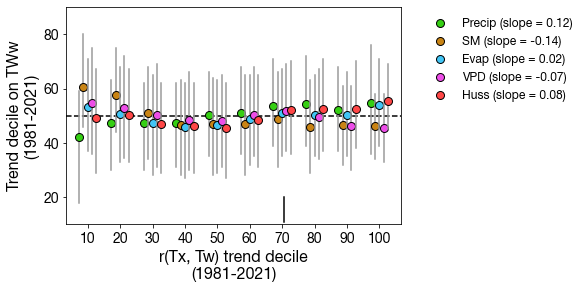

In [247]:
plt.figure(figsize=(6,4))
plt.xlim([0,31])
plt.ylim([10,90])
deciles = np.arange(10, 101, 10) 

plt.plot([0,31], [50,50], '--', color='k')

plt.plot([20.2,20.2], [11,20], '-k')

x = 2
offset=.4

marker_size = 8
for i in deciles:

 
    cur_x = x - .8
    y1 = np.nanpercentile(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x,cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#35cf13', mew=1, label='Precip (slope = %.2f)'%mdl_pr.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#35cf13', mew=1)
        
    cur_x = x - .4
    y1 = np.nanpercentile(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#c98414', mew=1, label='SM (slope = %.2f)'%mdl_sm.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#c98414', mew=1)
        
        
    cur_x = x
    y1 = np.nanpercentile(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#42c5f5', mew=1, label='Evap (slope = %.2f)'%mdl_evap.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#42c5f5', mew=1)
        
        
    cur_x = x + .4
    y1 = np.nanpercentile(vpd_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(vpd_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(vpd_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#ed4ee8', mew=1, label='VPD (slope = %.2f)'%mdl_vpd.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(vpd_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#ed4ee8', mew=1)
    
    
    cur_x = x + .8
    y1 = np.nanpercentile(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#ff4747', mew=1, label='Huss (slope = %.2f)'%mdl_huss.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=marker_size, mec='k', mfc='#ff4747', mew=1)
    
    
    x+=3


    
plt.xticks(np.arange(2,31,3))
plt.gca().set_xticklabels(deciles)
plt.xlabel('r(Tx, Tw) trend decile\n(1981-2021)')

if use_tx:
    plt.ylabel('Trend decile on TXx\n(1981-2021)')
else:
    plt.ylabel('Trend decile on TWw\n(1981-2021)')

plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')

if use_tx:
    plt.savefig('r(tx,tw)-pct-chg-vs-huss-evap-pr-sm-vpd-pct-on-tx-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
else:
    plt.savefig('r(tx,tw)-pct-chg-vs-huss-evap-pr-sm-vpd-pct-on-tw-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [89]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tx_on_tw_trend['tx_on_tw_trend'].values.reshape([tx_on_tw_trend['tx_on_tw_trend'].values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ed4ee8', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ =\n%.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.yticks([-1.5, -1, -.5, 0, .5, 1, 1.5])
plt.xticks([-.2, -.1, 0, .1, .2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('VPD on TXx trend\n(kPa/decade)')
# plt.savefig('r(tx,tw)-vs-vpd-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

NameError: name 'tx_on_tw_trend' is not defined

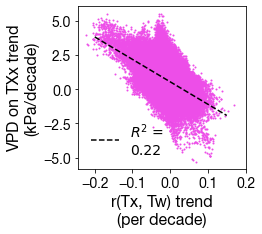

In [282]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = vpd_on_txx_trend['vpd_daily_mean_on_txx_trend'].values.reshape([vpd_on_txx_trend['vpd_daily_mean_on_txx_trend'].values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ed4ee8', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ =\n%.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.yticks([-1.5, -1, -.5, 0, .5, 1, 1.5])
plt.xticks([-.2, -.1, 0, .1, .2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('VPD on TXx trend\n(kPa/decade)')
plt.savefig('r(tx,tw)-vs-vpd-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

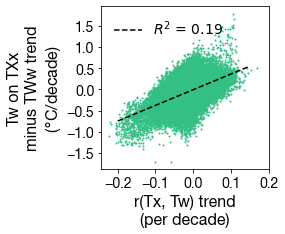

In [57]:


v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tw_on_txx_minus_tw_on_tww_trend.tw_on_txx_minus_tw_on_tww_trend.values.reshape([tw_on_txx_minus_tw_on_tww_trend.tw_on_txx_minus_tw_on_tww_trend.values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1.5, -1, -.5, 0, .5, 1, 1.5])
plt.xticks([-.2, -.1, 0, .1, .2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tw on TXx\nminus TWw trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tw_on_txx_minus_tw_on_tww-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

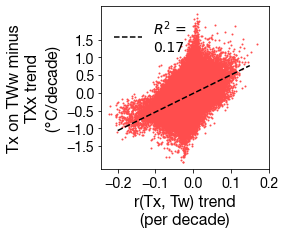

In [58]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tx_on_tww_minus_tx_on_txx_trend.tx_on_tww_minus_tx_on_txx_trend.values.reshape([tx_on_tww_minus_tx_on_txx_trend.tx_on_tww_minus_tx_on_txx_trend.values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ff4d4d', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ =\n%.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1.5, -1, -.5, 0, .5, 1, 1.5])
plt.xticks([-.2, -.1, 0, .1, .2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tx on TWw minus\nTXx trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tx_on_tww_minus_tx_on_txx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

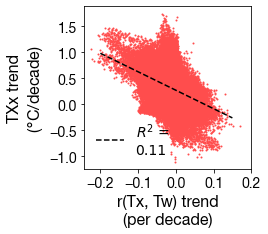

In [59]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tx_on_txx_trend.tx_on_txx_trend.values.reshape([tx_on_txx_trend.tx_on_txx_trend.values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ff4d4d', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ =\n%.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1, -.5, 0, .5, 1, 1.5])
plt.xticks([-.2, -.1, 0, .1, 0.2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('TXx trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tw_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

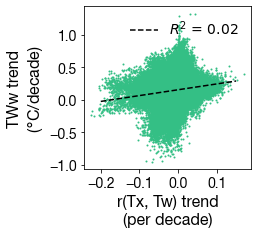

In [60]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tw_on_tww_trend.tw_on_tww_trend.values.reshape([tw_on_tww_trend.tw_on_tww_trend.values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('TWw trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tww-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

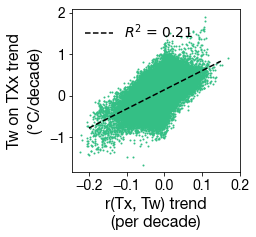

In [61]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tw_on_txx_trend.tw_on_txx_trend.values.reshape(tw_on_txx_trend.tw_on_txx_trend.values.size) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1, 0, 1, 2])
plt.xticks([-.2, -.1, 0, .1, .2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tw on TXx trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tw_on_txx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

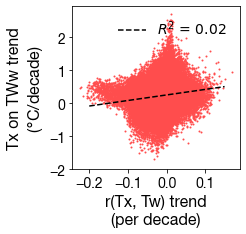

In [62]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tx_on_tww_trend.tx_on_tww_trend.values.reshape(tx_on_tww_trend.tx_on_tww_trend.values.size) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ff4d4d', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.yticks([-2, -1, 0, 1, 2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tx on TWw trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tx_on_tww-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)